<a href="https://colab.research.google.com/github/shivman/FOSS/blob/main/Stiker_prediction2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikeras

In [2]:
!pip install --upgrade scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 61.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: scikeras
    Found existing installation: scikeras 0.12.0
    Uninstalling scikeras-0.12.0:
      Successfully uninstalled scikeras-0.12.0


In [3]:
import sklearn
import scikeras
print("scikit-learn version:", sklearn.__version__)
print("scikeras version:", scikeras.__version__)

KeyboardInterrupt: 

In [ ]:
!pip install scikit-learn==1.2.2 scikeras==0.12.0

In [ ]:
import sklearn
import scikeras
print("scikit-learn version:", sklearn.__version__)  # Should be 1.2.2
print("scikeras version:", scikeras.__version__)     # Should be 0.12.0

In [ ]:
# Forecasting Sticker Sales
# Note: Install compatible versions: !pip install scikit-learn==1.2.2 scikeras==0.12.0
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
import warnings
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.models import Model
from scikeras.wrappers import KerasRegressor
import os

# Disable GPU to ensure stability (remove if GPU is properly configured)
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

warnings.filterwarnings("ignore")

# Load Dataset
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print("train_data shape:", train_data.shape)
print("test_data shape:", test_data.shape)
print("sample_submission shape:", sample_submission.shape)

# Visualization (Before Preprocessing)
plt.figure(figsize=(28, 6))
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.groupby('date')['num_sold'].sum().plot(xlabel='Date', ylabel='Number of Products Sold', title='Total Sales Over Time')
plt.grid()
plt.show()

plt.figure(figsize=(28, 6))
sns.barplot(x=train_data['date'].dt.year, y=train_data['num_sold'], hue=train_data['country'], estimator='sum', palette='deep')
plt.title('Sales Trends by Country (Year-wise)')
plt.xlabel('Year')
plt.ylabel('Number of Products Sold')
plt.legend(title='Country')
plt.grid()
plt.show()

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.histplot(train_data['num_sold'], kde=True, bins=30, color='violet')
plt.title('Distribution of Sticker Sales (num_sold)', fontsize=16)
plt.xlabel('Number of Stickers Sold')
plt.ylabel('Frequency')
plt.show()

# Preprocessing
def preprocess_data(df):
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['Year'] = df['date'].dt.year
    df['Month'] = df['date'].dt.month
    df['Day'] = df['date'].dt.day
    df['Day_of_Week'] = df['date'].dt.dayofweek
    df.drop(['date', 'id'], axis=1, inplace=True, errors='ignore')
    return df

train_data = train_data.dropna()
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Encoding Categorical Columns
cat_cols = ['country', 'store', 'product']
train_data = pd.get_dummies(train_data, columns=cat_cols, drop_first=True)
test_data = pd.get_dummies(test_data, columns=cat_cols, drop_first=True)
test_data = test_data.reindex(columns=train_data.columns.drop('num_sold'), fill_value=0)

# Define Features and Target
X = train_data.drop('num_sold', axis=1)
y = np.log1p(train_data['num_sold'])

# Correlation Matrix
correlation_matrix = train_data.corr()
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

print("\nCorrelation with target variable (num_sold):")
print(correlation_matrix['num_sold'].sort_values(ascending=False))

# Split Dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to NumPy arrays with float32 dtype
X_train = X_train.to_numpy().astype(np.float32)
X_val = X_val.to_numpy().astype(np.float32)
y_train = y_train.to_numpy().astype(np.float32)
y_val = y_val.to_numpy().astype(np.float32)
X = X.to_numpy().astype(np.float32)  # For cross-validation
y = y.to_numpy().astype(np.float32)
test_data = test_data.to_numpy().astype(np.float32)

# Evaluation Function
def evaluate_model(model, X_train, X_val, y_train, y_val, is_tf_model=False):
    try:
        if is_tf_model:
            model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0, validation_data=(X_val, y_val))
            y_pred = np.expm1(model.predict(X_val, verbose=0).flatten())
        else:
            model.fit(X_train, y_train)
            y_pred = np.expm1(model.predict(X_val))
        y_val_orig = np.expm1(y_val)
        mape_score = mean_absolute_percentage_error(y_val_orig, y_pred)
        return mape_score
    except Exception as e:
        print(f"Error evaluating model: {e}")
        return None

# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(1,), initializer='zeros', trainable=True)

    def call(self, inputs):
        e = tf.tanh(tf.matmul(inputs, self.W) + self.b)
        alpha = tf.nn.softmax(e, axis=-1)
        context = inputs * alpha
        return tf.reduce_sum(context, axis=-1, keepdims=True)

# Build Attention Model
def build_attention_model(input_shape, learning_rate=0.001):
    inputs = Input(shape=(input_shape,))
    x = Dense(64, activation='relu')(inputs)
    x = AttentionLayer()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['mape'])
    return model

# Base Models
print("\nBase Model Evaluation")
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_mape = evaluate_model(rf, X_train, X_val, y_train, y_val)
print(f"Random Forest MAPE: {rf_mape:.4f}")

xgb = XGBRegressor(random_state=42, verbosity=0, n_jobs=-1)
xgb_mape = evaluate_model(xgb, X_train, X_val, y_train, y_val)
print(f"XGBoost MAPE: {xgb_mape:.4f}")

attention_model = build_attention_model(X_train.shape[1])
attention_mape = evaluate_model(attention_model, X_train, X_val, y_train, y_val, is_tf_model=True)
if attention_mape is not None:
    print(f"Attention Model MAPE: {attention_mape:.4f}")
else:
    print("Attention Model evaluation failed.")

# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print("\nCross-Validation")
rf_cv_scores = cross_val_score(rf, X, y, scoring='neg_mean_absolute_percentage_error', cv=kf)
rf_cv_mape = -np.mean(rf_cv_scores)
print(f"Random Forest CV MAPE: {rf_cv_mape:.4f}")

xgb_cv_scores = cross_val_score(xgb, X, y, scoring='neg_mean_absolute_percentage_error', cv=kf)
xgb_cv_mape = -np.mean(xgb_cv_scores)
print(f"XGBoost CV MAPE: {xgb_cv_mape:.4f}")

attention_wrapped = KerasRegressor(model=lambda: build_attention_model(X_train.shape[1]), epochs=20, batch_size=32, verbose=0)
try:
    attention_cv_scores = cross_val_score(attention_wrapped, X, y, scoring='neg_mean_absolute_percentage_error', cv=kf)
    attention_cv_mape = -np.mean(attention_cv_scores)
    print(f"Attention Model CV MAPE: {attention_cv_mape:.4f}")
except Exception as e:
    print(f"Error in Attention Model cross-validation: {e}")
    # Manual CV as fallback
    attention_cv_scores = []
    for train_idx, val_idx in kf.split(X):
        X_fold_train, X_fold_val = X[train_idx], X[val_idx]
        y_fold_train, y_fold_val = y[train_idx], y[val_idx]
        fold_model = build_attention_model(X_train.shape[1])
        fold_mape = evaluate_model(fold_model, X_fold_train, X_fold_val, y_fold_train, y_fold_val, is_tf_model=True)
        if fold_mape is not None:
            attention_cv_scores.append(-fold_mape)  # Negate for consistency with neg_mean_absolute_percentage_error
    if attention_cv_scores:
        attention_cv_mape = -np.mean(attention_cv_scores)
        print(f"Attention Model Manual CV MAPE: {attention_cv_mape:.4f}")
    else:
        attention_cv_mape = None
        print("Manual CV for Attention Model failed.")

# Hyperparameter Tuning
print("\nHyperparameter Tuning")
rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
rf_random = RandomizedSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), param_distributions=rf_params, n_iter=20, scoring='neg_mean_absolute_percentage_error', cv=kf, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)
print(f"Best Random Forest Params: {rf_random.best_params_}")

xgb_params = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 6, 9], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0]}
xgb_random = RandomizedSearchCV(XGBRegressor(random_state=42, verbosity=0, n_jobs=-1), param_distributions=xgb_params, n_iter=20, scoring='neg_mean_absolute_percentage_error', cv=kf, random_state=42, n_jobs=-1)
xgb_random.fit(X_train, y_train)
print(f"Best XGBoost Params: {xgb_random.best_params_}")

attention_params = {'model__learning_rate': [0.001, 0.01, 0.1], 'epochs': [20, 30], 'batch_size': [32, 64]}
attention_random = RandomizedSearchCV(estimator=attention_wrapped, param_distributions=attention_params, n_iter=10, scoring='neg_mean_absolute_percentage_error', cv=kf, random_state=42, n_jobs=1)
try:
    attention_random.fit(X_train, y_train)
    print(f"Best Attention Model Params: {attention_random.best_params_}")
except Exception as e:
    print(f"Error in Attention Model hyperparameter tuning: {e}")
    attention_random = None

# Final Evaluation
print("\nFinal Model Evaluation")
rf_best = rf_random.best_estimator_
rf_best_mape = evaluate_model(rf_best, X_train, X_val, y_train, y_val)
print(f"Tuned Random Forest MAPE: {rf_best_mape:.4f}")

xgb_best = xgb_random.best_estimator_
xgb_best_mape = evaluate_model(xgb_best, X_train, X_val, y_train, y_val)
print(f"Tuned XGBoost MAPE: {xgb_best_mape:.4f}")

attention_best = attention_random.best_estimator_ if attention_random is not None else None
attention_best_mape = evaluate_model(attention_best, X_train, X_val, y_train, y_val, is_tf_model=True) if attention_best is not None else None
if attention_best_mape is not None:
    print(f"Tuned Attention Model MAPE: {attention_best_mape:.4f}")
else:
    print("Tuned Attention Model evaluation failed or tuning not completed.")

# Model Comparison
models_comparison = pd.DataFrame({
    'Model': ['Random Forest (Base)', 'XGBoost (Base)', 'Attention Model (Base)', 'Random Forest (Tuned)', 'XGBoost (Tuned)', 'Attention Model (Tuned)'],
    'MAPE': [rf_mape, xgb_mape, attention_mape if attention_mape is not None else np.nan,
             rf_best_mape, xgb_best_mape, attention_best_mape if attention_best_mape is not None else np.nan]
})
print("\nModel Comparison Table:")
print(models_comparison)

# Visualization of Model Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='MAPE', data=models_comparison, palette='viridis')
plt.title('Model Performance Comparison (MAPE)')
plt.ylabel('Mean Absolute Percentage Error')
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Feature Importance (XGBoost)
best_model = xgb_best
importance_df = pd.DataFrame({"Feature Name": X.columns, "Importance": best_model.feature_importances_}).sort_values(by="Importance", ascending=False)
print("\nFeature Importance Table (XGBoost):")
print(importance_df)

plt.figure(figsize=(10, 6))
plt.bar(range(len(best_model.feature_importances_)), best_model.feature_importances_)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

# Residual Analysis (All Models)
plt.figure(figsize=(12, 8))
for model, name in [(rf, 'Random Forest (Base)'), (xgb, 'XGBoost (Base)'), (xgb_best, 'XGBoost (Tuned)')]:
    residuals = np.expm1(y_val) - np.expm1(model.predict(X_val))
    sns.kdeplot(residuals, label=name, fill=True)
if attention_mape is not None:
    residuals_attention = np.expm1(y_val) - np.expm1(attention_model.predict(X_val, verbose=0).flatten())
    sns.kdeplot(residuals_attention, label='Attention Model (Base)', fill=True)
if attention_best_mape is not None:
    residuals_attention_best = np.expm1(y_val) - np.expm1(attention_best.predict(X_val, verbose=0).flatten())
    sns.kdeplot(residuals_attention_best, label='Attention Model (Tuned)', fill=True)
plt.title('Residuals Distribution Comparison', fontsize=16)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()

# Attention Layer Weights Analysis (Tuned Model, if successful)
if attention_best_mape is not None:
    attention_weights = attention_random.best_estimator_.model_.layers[1].get_weights()[0].flatten()
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(attention_weights)), attention_weights)
    plt.title('Tuned Attention Layer Weights')
    plt.xlabel('Feature Index (After Dense Layer)')
    plt.ylabel('Weight Value')
    plt.grid()
    plt.show()

# Prediction and Submission (XGBoost)
final_preds = np.expm1(xgb_best.predict(test_data))
submission = pd.DataFrame({'id': sample_submission['id'], 'num_sold': final_preds})
submission.to_csv('submission_xgb_rf.csv', index=False)
print("Submission file saved as submission_xgb_rf.csv")
print("\nFinal Predicted Entries (XGBoost):")
print(submission.head())

# Prediction and Submission (Tuned Attention Model, if successful)
if attention_best_mape is not None:
    final_preds_attention = np.expm1(attention_best.predict(test_data, verbose=0).flatten())
    submission_attention = pd.DataFrame({'id': sample_submission['id'], 'num_sold': final_preds_attention})
    submission_attention.to_csv('submission_attention.csv', index=False)
    print("Submission file saved as submission_attention.csv")
    print("\nFinal Predicted Entries (Tuned Attention Model):")
    print(submission_attention.head())

In [ ]:
# Forecasting Sticker Sales in Google Colab with GPU Support
# Install compatible versions for scikit-learn and scikeras
!pip install scikit-learn==1.2.2 scikeras==0.12.0 -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
import warnings
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.models import Model
from scikeras.wrappers import KerasRegressor
import os

# Verify GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

warnings.filterwarnings("ignore")

# Load Dataset
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print("train_data shape:", train_data.shape)
print("test_data shape:", test_data.shape)
print("sample_submission shape:", sample_submission.shape)

# Visualization (Before Preprocessing)
plt.figure(figsize=(28, 6))
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.groupby('date')['num_sold'].sum().plot(xlabel='Date', ylabel='Number of Products Sold', title='Total Sales Over Time')
plt.grid()
plt.show()

plt.figure(figsize=(28, 6))
sns.barplot(x=train_data['date'].dt.year, y=train_data['num_sold'], hue=train_data['country'], estimator='sum', palette='deep')
plt.title('Sales Trends by Country (Year-wise)')
plt.xlabel('Year')
plt.ylabel('Number of Products Sold')
plt.legend(title='Country')
plt.grid()
plt.show()

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.histplot(train_data['num_sold'], kde=True, bins=30, color='violet')
plt.title('Distribution of Sticker Sales (num_sold)', fontsize=16)
plt.xlabel('Number of Stickers Sold')
plt.ylabel('Frequency')
plt.show()

# Preprocessing
def preprocess_data(df):
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['Year'] = df['date'].dt.year
    df['Month'] = df['date'].dt.month
    df['Day'] = df['date'].dt.day
    df['Day_of_Week'] = df['date'].dt.dayofweek
    df.drop(['date', 'id'], axis=1, inplace=True, errors='ignore')
    return df

train_data = train_data.dropna()
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Encoding Categorical Columns
cat_cols = ['country', 'store', 'product']
train_data = pd.get_dummies(train_data, columns=cat_cols, drop_first=True)
test_data = pd.get_dummies(test_data, columns=cat_cols, drop_first=True)
test_data = test_data.reindex(columns=train_data.columns.drop('num_sold'), fill_value=0)

# Define Features and Target
X = train_data.drop('num_sold', axis=1)
y = np.log1p(train_data['num_sold'])

# Correlation Matrix
correlation_matrix = train_data.corr()
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

print("\nCorrelation with target variable (num_sold):")
print(correlation_matrix['num_sold'].sort_values(ascending=False))

# Split Dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to NumPy arrays with float32 dtype
X_train = X_train.to_numpy().astype(np.float32)
X_val = X_val.to_numpy().astype(np.float32)
y_train = y_train.to_numpy().astype(np.float32)
y_val = y_val.to_numpy().astype(np.float32)
X = X.to_numpy().astype(np.float32)  # For cross-validation
y = y.to_numpy().astype(np.float32)
test_data = test_data.to_numpy().astype(np.float32)

# Evaluation Function
def evaluate_model(model, X_train, X_val, y_train, y_val, is_tf_model=False):
    try:
        if is_tf_model:
            # Use GPU for training
            with tf.device('/GPU:0'):
                model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0, validation_data=(X_val, y_val))
            y_pred = np.expm1(model.predict(X_val, verbose=0).flatten())
        else:
            model.fit(X_train, y_train)
            y_pred = np.expm1(model.predict(X_val))
        y_val_orig = np.expm1(y_val)
        mape_score = mean_absolute_percentage_error(y_val_orig, y_pred)
        return mape_score
    except Exception as e:
        print(f"Error evaluating model: {e}")
        return None

# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(1,), initializer='zeros', trainable=True)

    def call(self, inputs):
        e = tf.tanh(tf.matmul(inputs, self.W) + self.b)
        alpha = tf.nn.softmax(e, axis=-1)
        context = inputs * alpha
        return tf.reduce_sum(context, axis=-1, keepdims=True)

# Build Attention Model
def build_attention_model(input_shape, learning_rate=0.001):
    inputs = Input(shape=(input_shape,))
    x = Dense(64, activation='relu')(inputs)
    x = AttentionLayer()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['mape'])
    return model

# Base Models
print("\nBase Model Evaluation")
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_mape = evaluate_model(rf, X_train, X_val, y_train, y_val)
print(f"Random Forest MAPE: {rf_mape:.4f}")

xgb = XGBRegressor(random_state=42, verbosity=0, n_jobs=-1)
xgb_mape = evaluate_model(xgb, X_train, X_val, y_train, y_val)
print(f"XGBoost MAPE: {xgb_mape:.4f}")

attention_model = build_attention_model(X_train.shape[1])
attention_mape = evaluate_model(attention_model, X_train, X_val, y_train, y_val, is_tf_model=True)
if attention_mape is not None:
    print(f"Attention Model MAPE: {attention_mape:.4f}")
else:
    print("Attention Model evaluation failed.")

# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print("\nCross-Validation")
rf_cv_scores = cross_val_score(rf, X, y, scoring='neg_mean_absolute_percentage_error', cv=kf)
rf_cv_mape = -np.mean(rf_cv_scores)
print(f"Random Forest CV MAPE: {rf_cv_mape:.4f}")

xgb_cv_scores = cross_val_score(xgb, X, y, scoring='neg_mean_absolute_percentage_error', cv=kf)
xgb_cv_mape = -np.mean(xgb_cv_scores)
print(f"XGBoost CV MAPE: {xgb_cv_mape:.4f}")

attention_wrapped = KerasRegressor(model=lambda: build_attention_model(X_train.shape[1]), epochs=20, batch_size=32, verbose=0)
try:
    attention_cv_scores = cross_val_score(attention_wrapped, X, y, scoring='neg_mean_absolute_percentage_error', cv=kf)
    attention_cv_mape = -np.mean(attention_cv_scores)
    print(f"Attention Model CV MAPE: {attention_cv_mape:.4f}")
except Exception as e:
    print(f"Error in Attention Model cross-validation: {e}")
    attention_cv_mape = None

# Hyperparameter Tuning
print("\nHyperparameter Tuning")
rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
rf_random = RandomizedSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), param_distributions=rf_params, n_iter=20, scoring='neg_mean_absolute_percentage_error', cv=kf, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)
print(f"Best Random Forest Params: {rf_random.best_params_}")

xgb_params = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 6, 9], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0]}
xgb_random = RandomizedSearchCV(XGBRegressor(random_state=42, verbosity=0, n_jobs=-1), param_distributions=xgb_params, n_iter=20, scoring='neg_mean_absolute_percentage_error', cv=kf, random_state=42, n_jobs=-1)
xgb_random.fit(X_train, y_train)
print(f"Best XGBoost Params: {xgb_random.best_params_}")

attention_params = {'model__learning_rate': [0.001, 0.01, 0.1], 'epochs': [20, 30], 'batch_size': [32, 64]}
attention_random = RandomizedSearchCV(estimator=attention_wrapped, param_distributions=attention_params, n_iter=10, scoring='neg_mean_absolute_percentage_error', cv=kf, random_state=42, n_jobs=1)
try:
    attention_random.fit(X_train, y_train)
    print(f"Best Attention Model Params: {attention_random.best_params_}")
except Exception as e:
    print(f"Error in Attention Model hyperparameter tuning: {e}")
    attention_random = None

# Final Evaluation
print("\nFinal Model Evaluation")
rf_best = rf_random.best_estimator_
rf_best_mape = evaluate_model(rf_best, X_train, X_val, y_train, y_val)
print(f"Tuned Random Forest MAPE: {rf_best_mape:.4f}")

xgb_best = xgb_random.best_estimator_
xgb_best_mape = evaluate_model(xgb_best, X_train, X_val, y_train, y_val)
print(f"Tuned XGBoost MAPE: {xgb_best_mape:.4f}")

attention_best = attention_random.best_estimator_ if attention_random is not None else None
attention_best_mape = evaluate_model(attention_best, X_train, X_val, y_train, y_val, is_tf_model=True) if attention_best is not None else None
if attention_best_mape is not None:
    print(f"Tuned Attention Model MAPE: {attention_best_mape:.4f}")
else:
    print("Tuned Attention Model evaluation failed or tuning not completed.")

# Model Comparison
models_comparison = pd.DataFrame({
    'Model': ['Random Forest (Base)', 'XGBoost (Base)', 'Attention Model (Base)', 'Random Forest (Tuned)', 'XGBoost (Tuned)', 'Attention Model (Tuned)'],
    'MAPE': [rf_mape, xgb_mape, attention_mape if attention_mape is not None else np.nan,
             rf_best_mape, xgb_best_mape, attention_best_mape if attention_best_mape is not None else np.nan]
})
print("\nModel Comparison Table:")
print(models_comparison)

# Visualization of Model Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='MAPE', data=models_comparison, palette='viridis')
plt.title('Model Performance Comparison (MAPE)')
plt.ylabel('Mean Absolute Percentage Error')
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Feature Importance (XGBoost)
best_model = xgb_best
importance_df = pd.DataFrame({"Feature Name": X.columns, "Importance": best_model.feature_importances_}).sort_values(by="Importance", ascending=False)
print("\nFeature Importance Table (XGBoost):")
print(importance_df)

plt.figure(figsize=(10, 6))
plt.bar(range(len(best_model.feature_importances_)), best_model.feature_importances_)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

# Residual Analysis (All Models)
plt.figure(figsize=(12, 8))
for model, name in [(rf, 'Random Forest (Base)'), (xgb, 'XGBoost (Base)'), (xgb_best, 'XGBoost (Tuned)')]:
    residuals = np.expm1(y_val) - np.expm1(model.predict(X_val))
    sns.kdeplot(residuals, label=name, fill=True)
if attention_mape is not None:
    residuals_attention = np.expm1(y_val) - np.expm1(attention_model.predict(X_val, verbose=0).flatten())
    sns.kdeplot(residuals_attention, label='Attention Model (Base)', fill=True)
if attention_best_mape is not None:
    residuals_attention_best = np.expm1(y_val) - np.expm1(attention_best.predict(X_val, verbose=0).flatten())
    sns.kdeplot(residuals_attention_best, label='Attention Model (Tuned)', fill=True)
plt.title('Residuals Distribution Comparison', fontsize=16)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()

# Attention Layer Weights Analysis (Tuned Model, if successful)
if attention_best_mape is not None:
    attention_weights = attention_random.best_estimator_.model_.layers[1].get_weights()[0].flatten()
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(attention_weights)), attention_weights)
    plt.title('Tuned Attention Layer Weights')
    plt.xlabel('Feature Index (After Dense Layer)')
    plt.ylabel('Weight Value')
    plt.grid()
    plt.show()

# Prediction and Submission (XGBoost)
final_preds = np.expm1(xgb_best.predict(test_data))
submission = pd.DataFrame({'id': sample_submission['id'], 'num_sold': final_preds})
submission.to_csv('submission_xgb_rf.csv', index=False)
print("Submission file saved as submission_xgb_rf.csv")
print("\nFinal Predicted Entries (XGBoost):")
print(submission.head())

# Prediction and Submission (Tuned Attention Model, if successful)
if attention_best_mape is not None:
    final_preds_attention = np.expm1(attention_best.predict(test_data, verbose=0).flatten())
    submission_attention = pd.DataFrame({'id': sample_submission['id'], 'num_sold': final_preds_attention})
    submission_attention.to_csv('submission_attention.csv', index=False)
    print("Submission file saved as submission_attention.csv")
    print("\nFinal Predicted Entries (Tuned Attention Model):")
    print(submission_attention.head())

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
!pip install scikeras -q

In [4]:
# Forecasting Sticker Sales in Google Colab with GPU Support
# Ensure GPU is enabled: Runtime > Change runtime type > Select GPU > Save
# Install compatible versions
!pip install scikit-learn==1.2.2 scikeras==0.12.0 -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
import warnings
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.models import Model
from scikeras.wrappers import KerasRegressor

# Verify GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU detected and configured:", physical_devices)
else:
    print("No GPU detected. Running on CPU.")

warnings.filterwarnings("ignore")

# Load Dataset
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print("train_data shape:", train_data.shape)
print("test_data shape:", test_data.shape)
print("sample_submission shape:", sample_submission.shape)

# Visualization (Before Preprocessing)
plt.figure(figsize=(28, 6))
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.groupby('date')['num_sold'].sum().plot(xlabel='Date', ylabel='Number of Products Sold', title='Total Sales Over Time')
plt.grid()
plt.show()

plt.figure(figsize=(28, 6))
sns.barplot(x=train_data['date'].dt.year, y=train_data['num_sold'], hue=train_data['country'], estimator='sum', palette='deep')
plt.title('Sales Trends by Country (Year-wise)')
plt.xlabel('Year')
plt.ylabel('Number of Products Sold')
plt.legend(title='Country')
plt.grid()
plt.show()

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.histplot(train_data['num_sold'], kde=True, bins=30, color='violet')
plt.title('Distribution of Sticker Sales (num_sold)', fontsize=16)
plt.xlabel('Number of Stickers Sold')
plt.ylabel('Frequency')
plt.show()

# Preprocessing
def preprocess_data(df):
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['Year'] = df['date'].dt.year
    df['Month'] = df['date'].dt.month
    df['Day'] = df['date'].dt.day
    df['Day_of_Week'] = df['date'].dt.dayofweek
    df.drop(['date', 'id'], axis=1, inplace=True, errors='ignore')
    return df

train_data = train_data.dropna()
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Encoding Categorical Columns
cat_cols = ['country', 'store', 'product']
train_data = pd.get_dummies(train_data, columns=cat_cols, drop_first=True)
test_data = pd.get_dummies(test_data, columns=cat_cols, drop_first=True)
test_data = test_data.reindex(columns=train_data.columns.drop('num_sold'), fill_value=0)

# Define Features and Target
X = train_data.drop('num_sold', axis=1)
y = np.log1p(train_data['num_sold'])

# Correlation Matrix
correlation_matrix = train_data.corr()
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

print("\nCorrelation with target variable (num_sold):")
print(correlation_matrix['num_sold'].sort_values(ascending=False))

# Split Dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to NumPy arrays with float32 dtype
X_train = X_train.to_numpy().astype(np.float32)
X_val = X_val.to_numpy().astype(np.float32)
y_train = y_train.to_numpy().astype(np.float32)
y_val = y_val.to_numpy().astype(np.float32)
X = X.to_numpy().astype(np.float32)  # For cross-validation
y = y.to_numpy().astype(np.float32)
test_data = test_data.to_numpy().astype(np.float32)

# Evaluation Function
def evaluate_model(model, X_train, X_val, y_train, y_val, is_tf_model=False):
    try:
        if is_tf_model:
            # Use GPU for training if available
            with tf.device('/GPU:0'):
                model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0, validation_data=(X_val, y_val))
            y_pred = np.expm1(model.predict(X_val, verbose=0).flatten())
        else:
            model.fit(X_train, y_train)
            y_pred = np.expm1(model.predict(X_val))
        y_val_orig = np.expm1(y_val)
        mape_score = mean_absolute_percentage_error(y_val_orig, y_pred)
        return mape_score
    except Exception as e:
        print(f"Error evaluating model: {e}")
        return None

# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(1,), initializer='zeros', trainable=True)

    def call(self, inputs):
        e = tf.tanh(tf.matmul(inputs, self.W) + self.b)
        alpha = tf.nn.softmax(e, axis=-1)
        context = inputs * alpha
        return tf.reduce_sum(context, axis=-1, keepdims=True)

# Build Attention Model
def build_attention_model(input_shape, learning_rate=0.001):
    inputs = Input(shape=(input_shape,))
    x = Dense(64, activation='relu')(inputs)
    x = AttentionLayer()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['mape'])
    return model

# Base Models
print("\nBase Model Evaluation")
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_mape = evaluate_model(rf, X_train, X_val, y_train, y_val)
print(f"Random Forest MAPE: {rf_mape:.4f}")

xgb = XGBRegressor(random_state=42, verbosity=0, n_jobs=-1)
xgb_mape = evaluate_model(xgb, X_train, X_val, y_train, y_val)
print(f"XGBoost MAPE: {xgb_mape:.4f}")

attention_model = build_attention_model(X_train.shape[1])
attention_mape = evaluate_model(attention_model, X_train, X_val, y_train, y_val, is_tf_model=True)
if attention_mape is not None:
    print(f"Attention Model MAPE: {attention_mape:.4f}")
else:
    print("Attention Model evaluation failed.")

# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print("\nCross-Validation")
rf_cv_scores = cross_val_score(rf, X, y, scoring='neg_mean_absolute_percentage_error', cv=kf)
rf_cv_mape = -np.mean(rf_cv_scores)
print(f"Random Forest CV MAPE: {rf_cv_mape:.4f}")

xgb_cv_scores = cross_val_score(xgb, X, y, scoring='neg_mean_absolute_percentage_error', cv=kf)
xgb_cv_mape = -np.mean(xgb_cv_scores)
print(f"XGBoost CV MAPE: {xgb_cv_mape:.4f}")

attention_wrapped = KerasRegressor(model=lambda: build_attention_model(X_train.shape[1]), epochs=20, batch_size=32, verbose=0)
try:
    attention_cv_scores = cross_val_score(attention_wrapped, X, y, scoring='neg_mean_absolute_percentage_error', cv=kf)
    attention_cv_mape = -np.mean(attention_cv_scores)
    print(f"Attention Model CV MAPE: {attention_cv_mape:.4f}")
except Exception as e:
    print(f"Error in Attention Model cross-validation: {e}")
    attention_cv_mape = None

# Hyperparameter Tuning
print("\nHyperparameter Tuning")
rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
rf_random = RandomizedSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), param_distributions=rf_params, n_iter=20, scoring='neg_mean_absolute_percentage_error', cv=kf, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)
print(f"Best Random Forest Params: {rf_random.best_params_}")

xgb_params = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 6, 9], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0]}
xgb_random = RandomizedSearchCV(XGBRegressor(random_state=42, verbosity=0, n_jobs=-1), param_distributions=xgb_params, n_iter=20, scoring='neg_mean_absolute_percentage_error', cv=kf, random_state=42, n_jobs=-1)
xgb_random.fit(X_train, y_train)
print(f"Best XGBoost Params: {xgb_random.best_params_}")

attention_params = {'model__learning_rate': [0.001, 0.01, 0.1], 'epochs': [20, 30], 'batch_size': [32, 64]}
attention_random = RandomizedSearchCV(estimator=attention_wrapped, param_distributions=attention_params, n_iter=10, scoring='neg_mean_absolute_percentage_error', cv=kf, random_state=42, n_jobs=1)
try:
    attention_random.fit(X_train, y_train)
    print(f"Best Attention Model Params: {attention_random.best_params_}")
except Exception as e:
    print(f"Error in Attention Model hyperparameter tuning: {e}")
    attention_random = None

# Final Evaluation
print("\nFinal Model Evaluation")
rf_best = rf_random.best_estimator_
rf_best_mape = evaluate_model(rf_best, X_train, X_val, y_train, y_val)
print(f"Tuned Random Forest MAPE: {rf_best_mape:.4f}")

xgb_best = xgb_random.best_estimator_
xgb_best_mape = evaluate_model(xgb_best, X_train, X_val, y_train, y_val)
print(f"Tuned XGBoost MAPE: {xgb_best_mape:.4f}")

attention_best = attention_random.best_estimator_ if attention_random is not None else None
attention_best_mape = evaluate_model(attention_best, X_train, X_val, y_train, y_val, is_tf_model=True) if attention_best is not None else None
if attention_best_mape is not None:
    print(f"Tuned Attention Model MAPE: {attention_best_mape:.4f}")
else:
    print("Tuned Attention Model evaluation failed or tuning not completed.")

# Model Comparison
models_comparison = pd.DataFrame({
    'Model': ['Random Forest (Base)', 'XGBoost (Base)', 'Attention Model (Base)', 'Random Forest (Tuned)', 'XGBoost (Tuned)', 'Attention Model (Tuned)'],
    'MAPE': [rf_mape, xgb_mape, attention_mape if attention_mape is not None else np.nan,
             rf_best_mape, xgb_best_mape, attention_best_mape if attention_best_mape is not None else np.nan]
})
print("\nModel Comparison Table:")
print(models_comparison)

# Visualization of Model Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='MAPE', data=models_comparison, palette='viridis')
plt.title('Model Performance Comparison (MAPE)')
plt.ylabel('Mean Absolute Percentage Error')
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Feature Importance (XGBoost)
best_model = xgb_best
importance_df = pd.DataFrame({"Feature Name": X.columns, "Importance": best_model.feature_importances_}).sort_values(by="Importance", ascending=False)
print("\nFeature Importance Table (XGBoost):")
print(importance_df)

plt.figure(figsize=(10, 6))
plt.bar(range(len(best_model.feature_importances_)), best_model.feature_importances_)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

# Residual Analysis (All Models)
plt.figure(figsize=(12, 8))
for model, name in [(rf, 'Random Forest (Base)'), (xgb, 'XGBoost (Base)'), (xgb_best, 'XGBoost (Tuned)')]:
    residuals = np.expm1(y_val) - np.expm1(model.predict(X_val))
    sns.kdeplot(residuals, label=name, fill=True)
if attention_mape is not None:
    residuals_attention = np.expm1(y_val) - np.expm1(attention_model.predict(X_val, verbose=0).flatten())
    sns.kdeplot(residuals_attention, label='Attention Model (Base)', fill=True)
if attention_best_mape is not None:
    residuals_attention_best = np.expm1(y_val) - np.expm1(attention_best.predict(X_val, verbose=0).flatten())
    sns.kdeplot(residuals_attention_best, label='Attention Model (Tuned)', fill=True)
plt.title('Residuals Distribution Comparison', fontsize=16)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()

# Attention Layer Weights Analysis (Tuned Model, if successful)
if attention_best_mape is not None:
    attention_weights = attention_random.best_estimator_.model_.layers[1].get_weights()[0].flatten()
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(attention_weights)), attention_weights)
    plt.title('Tuned Attention Layer Weights')
    plt.xlabel('Feature Index (After Dense Layer)')
    plt.ylabel('Weight Value')
    plt.grid()
    plt.show()

# Prediction and Submission (XGBoost)
final_preds = np.expm1(xgb_best.predict(test_data))
submission = pd.DataFrame({'id': sample_submission['id'], 'num_sold': final_preds})
submission.to_csv('submission_xgb_rf.csv', index=False)
print("Submission file saved as submission_xgb_rf.csv")
print("\nFinal Predicted Entries (XGBoost):")
print(submission.head())

# Prediction and Submission (Tuned Attention Model, if successful)
if attention_best_mape is not None:
    final_preds_attention = np.expm1(attention_best.predict(test_data, verbose=0).flatten())
    submission_attention = pd.DataFrame({'id': sample_submission['id'], 'num_sold': final_preds_attention})
    submission_attention.to_csv('submission_attention.csv', index=False)
    print("Submission file saved as submission_attention.csv")
    print("\nFinal Predicted Entries (Tuned Attention Model):")
    print(submission_attention.head())

ImportError: cannot import name '_approximate_mode' from 'sklearn.utils' (/usr/local/lib/python3.11/dist-packages/sklearn/utils/__init__.py)

In [2]:
# Forecasting Sticker Sales in Google Colab with T4 GPU Support
# Reset runtime and reinstall scikit-learn to fix import error
# Step 1: Disconnect and delete runtime (Runtime > Disconnect and delete runtime)
# Step 2: Reconnect and run this cell

# Uninstall existing scikit-learn and reinstall a known good version
#!pip uninstall scikit-learn -y -q
#!pip install scikit-learn==1.5.2 scikeras -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
import warnings
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.models import Model
from scikeras.wrappers import KerasRegressor

# Verify GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)  # Avoid memory pre-allocation issues
    print("GPU detected and configured:", physical_devices)
else:
    print("No GPU detected. Ensure T4 GPU is selected (Runtime > Change runtime type > T4 GPU) and restart runtime.")

# Check versions
import sklearn
print("scikit-learn version:", sklearn.__version__)  # Should be 1.5.2
print("TensorFlow version:", tf.__version__)

warnings.filterwarnings("ignore")



Num GPUs Available:  1
GPU detected and configured: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
scikit-learn version: 1.5.2
TensorFlow version: 2.18.0


train_data shape: (230130, 6)
test_data shape: (98550, 5)
sample_submission shape: (98550, 2)


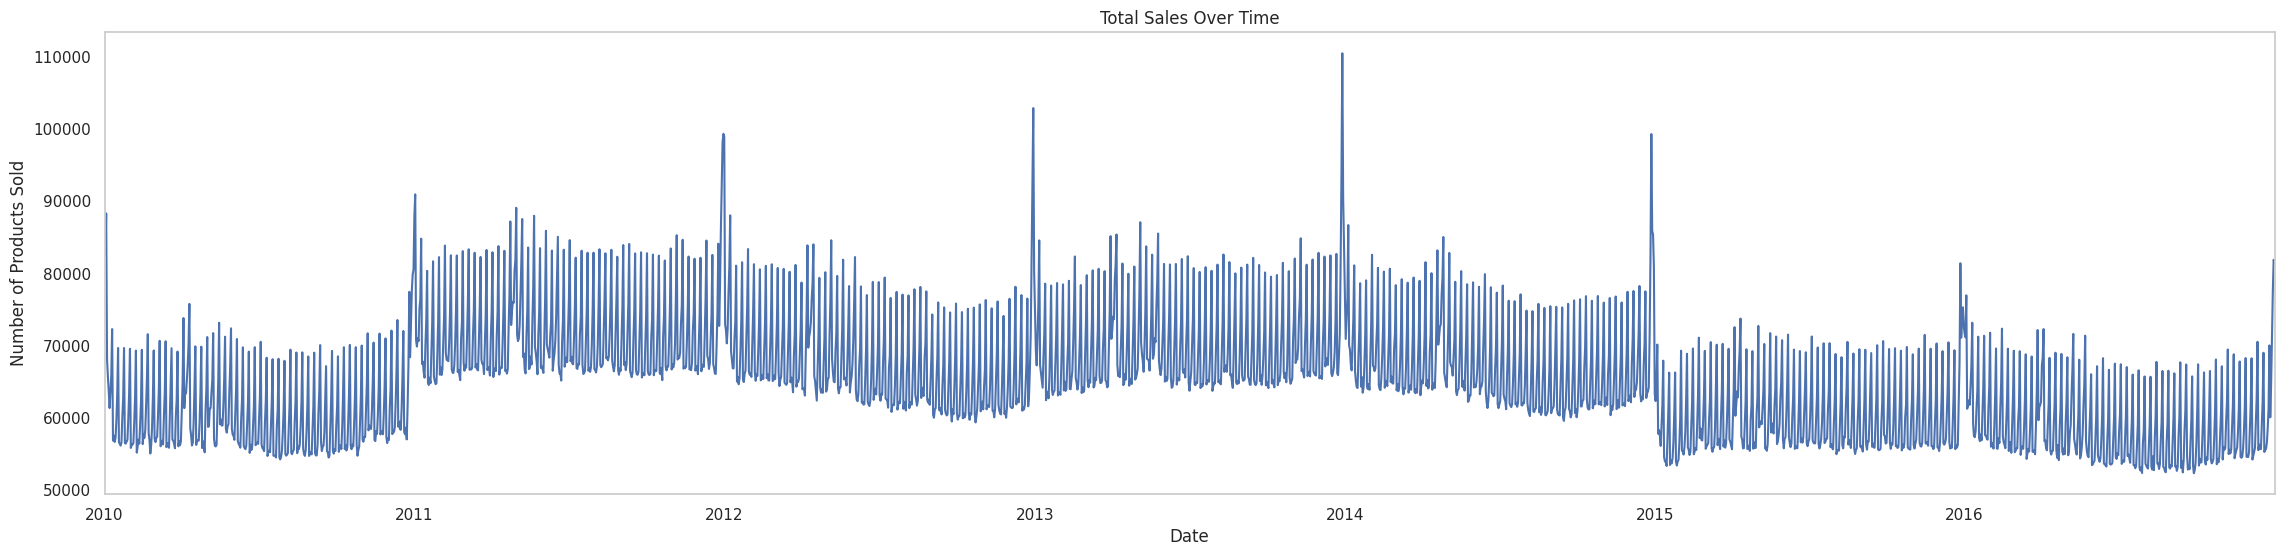

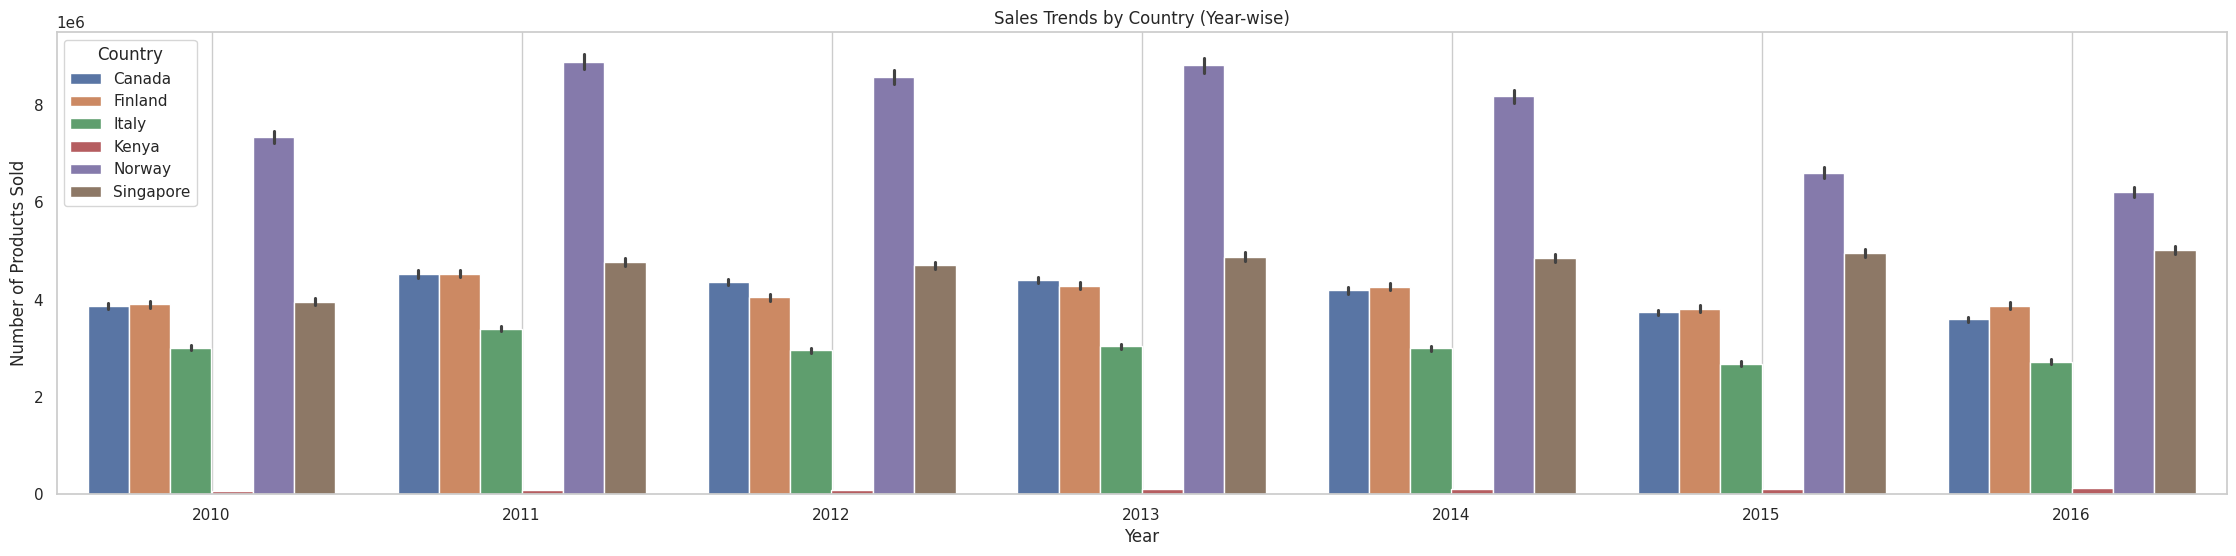

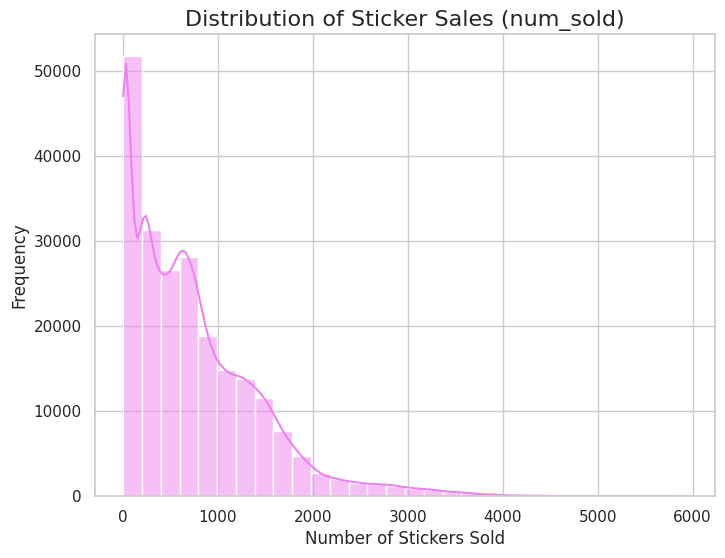

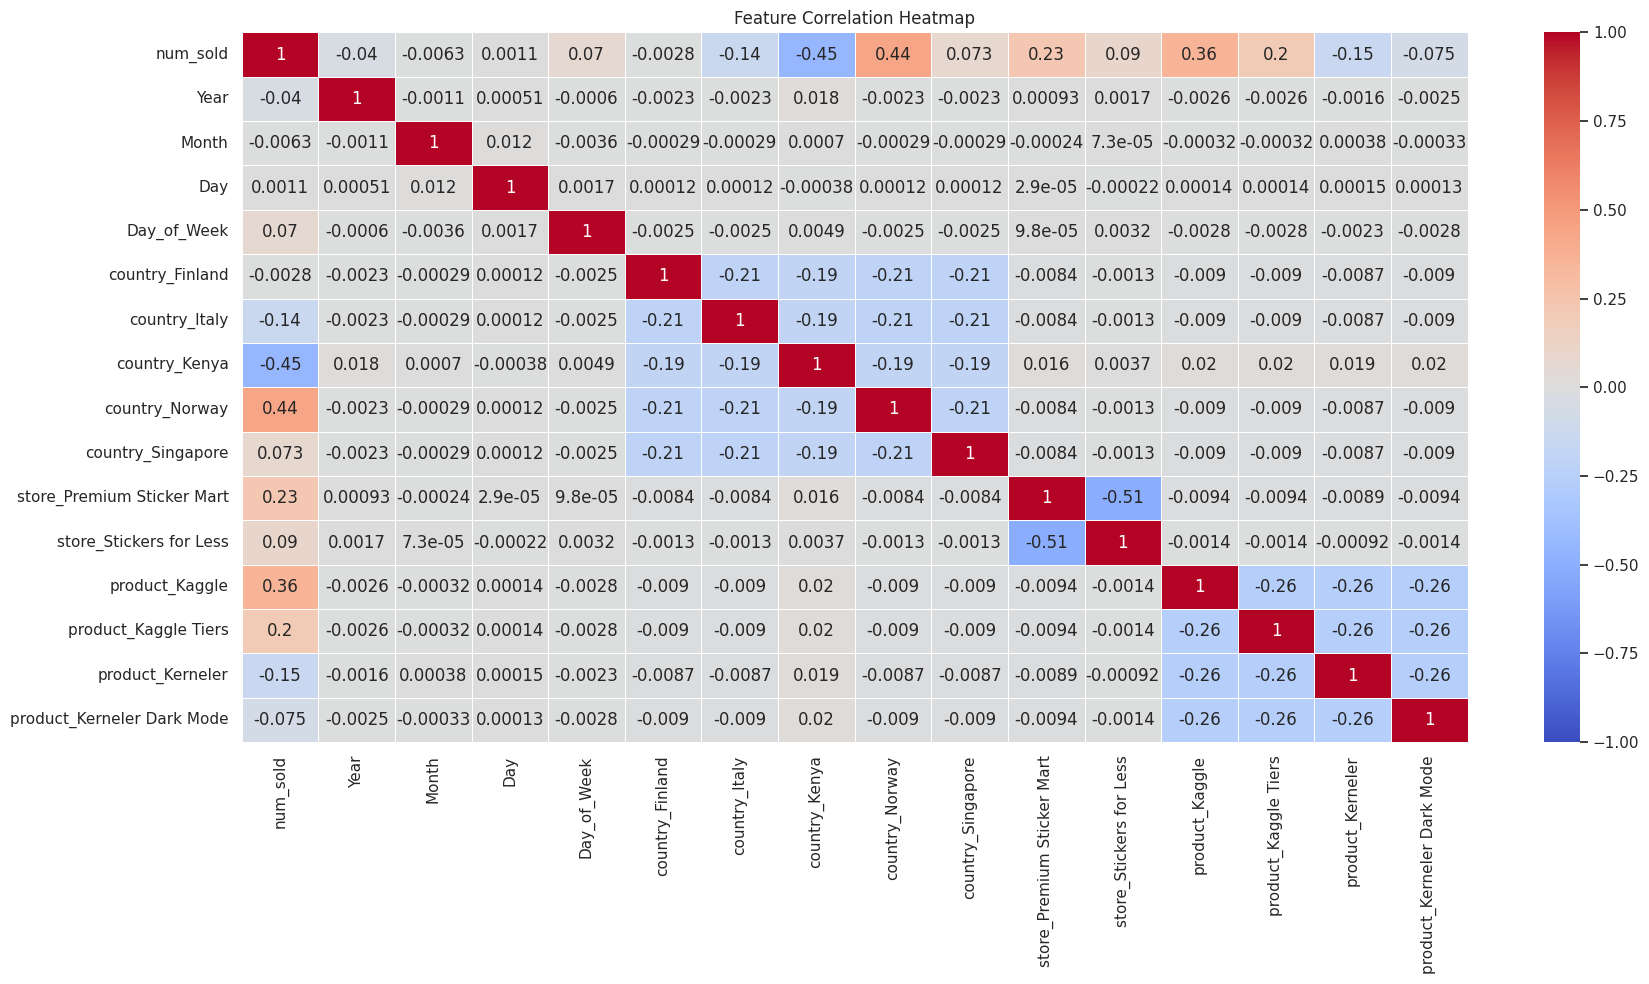


Correlation with target variable (num_sold):
num_sold                      1.000000
country_Norway                0.444573
product_Kaggle                0.356331
store_Premium Sticker Mart    0.231209
product_Kaggle Tiers          0.197389
store_Stickers for Less       0.089933
country_Singapore             0.073334
Day_of_Week                   0.069613
Day                           0.001137
country_Finland              -0.002843
Month                        -0.006255
Year                         -0.040462
product_Kerneler Dark Mode   -0.075360
country_Italy                -0.139527
product_Kerneler             -0.145131
country_Kenya                -0.449873
Name: num_sold, dtype: float64

Base Model Evaluation
Random Forest MAPE: 0.0516
XGBoost MAPE: 0.0459
Attention Model MAPE: 0.1640

Cross-Validation
Random Forest CV MAPE: 0.0095
XGBoost CV MAPE: 0.0087


KeyboardInterrupt: 

In [4]:

# Load Dataset
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print("train_data shape:", train_data.shape)
print("test_data shape:", test_data.shape)
print("sample_submission shape:", sample_submission.shape)

# Visualization (Before Preprocessing)
plt.figure(figsize=(28, 6))
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.groupby('date')['num_sold'].sum().plot(xlabel='Date', ylabel='Number of Products Sold', title='Total Sales Over Time')
plt.grid()
plt.show()

plt.figure(figsize=(28, 6))
sns.barplot(x=train_data['date'].dt.year, y=train_data['num_sold'], hue=train_data['country'], estimator='sum', palette='deep')
plt.title('Sales Trends by Country (Year-wise)')
plt.xlabel('Year')
plt.ylabel('Number of Products Sold')
plt.legend(title='Country')
plt.grid()
plt.show()

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.histplot(train_data['num_sold'], kde=True, bins=30, color='violet')
plt.title('Distribution of Sticker Sales (num_sold)', fontsize=16)
plt.xlabel('Number of Stickers Sold')
plt.ylabel('Frequency')
plt.show()

# Preprocessing
def preprocess_data(df):
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['Year'] = df['date'].dt.year
    df['Month'] = df['date'].dt.month
    df['Day'] = df['date'].dt.day
    df['Day_of_Week'] = df['date'].dt.dayofweek
    df.drop(['date', 'id'], axis=1, inplace=True, errors='ignore')
    return df

train_data = train_data.dropna()
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Encoding Categorical Columns
cat_cols = ['country', 'store', 'product']
train_data = pd.get_dummies(train_data, columns=cat_cols, drop_first=True)
test_data = pd.get_dummies(test_data, columns=cat_cols, drop_first=True)
test_data = test_data.reindex(columns=train_data.columns.drop('num_sold'), fill_value=0)  # Corrected from reindex_columns

# Define Features and Target
X = train_data.drop('num_sold', axis=1)
y = np.log1p(train_data['num_sold'])

# Correlation Matrix
correlation_matrix = train_data.corr()
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

print("\nCorrelation with target variable (num_sold):")
print(correlation_matrix['num_sold'].sort_values(ascending=False))

# Split Dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to NumPy arrays with float32 dtype
X_train = X_train.to_numpy().astype(np.float32)
X_val = X_val.to_numpy().astype(np.float32)
y_train = y_train.to_numpy().astype(np.float32)
y_val = y_val.to_numpy().astype(np.float32)
X = X.to_numpy().astype(np.float32)  # For cross-validation
y = y.to_numpy().astype(np.float32)
test_data = test_data.to_numpy().astype(np.float32)

# Evaluation Function
def evaluate_model(model, X_train, X_val, y_train, y_val, is_tf_model=False):
    try:
        if is_tf_model:
            # Use GPU for training if available
            with tf.device('/GPU:0'):
                model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0, validation_data=(X_val, y_val))
            y_pred = np.expm1(model.predict(X_val, verbose=0).flatten())
        else:
            model.fit(X_train, y_train)
            y_pred = np.expm1(model.predict(X_val))
        y_val_orig = np.expm1(y_val)
        mape_score = mean_absolute_percentage_error(y_val_orig, y_pred)
        return mape_score
    except Exception as e:
        print(f"Error evaluating model: {e}")
        return None

# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(1,), initializer='zeros', trainable=True)

    def call(self, inputs):
        e = tf.tanh(tf.matmul(inputs, self.W) + self.b)
        alpha = tf.nn.softmax(e, axis=-1)
        context = inputs * alpha
        return tf.reduce_sum(context, axis=-1, keepdims=True)

# Build Attention Model
def build_attention_model(input_shape, learning_rate=0.001):
    inputs = Input(shape=(input_shape,))
    x = Dense(64, activation='relu')(inputs)
    x = AttentionLayer()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['mape'])
    return model

# Base Models
print("\nBase Model Evaluation")
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_mape = evaluate_model(rf, X_train, X_val, y_train, y_val)
print(f"Random Forest MAPE: {rf_mape:.4f}")

xgb = XGBRegressor(random_state=42, verbosity=0, n_jobs=-1)
xgb_mape = evaluate_model(xgb, X_train, X_val, y_train, y_val)
print(f"XGBoost MAPE: {xgb_mape:.4f}")

attention_model = build_attention_model(X_train.shape[1])
attention_mape = evaluate_model(attention_model, X_train, X_val, y_train, y_val, is_tf_model=True)
if attention_mape is not None:
    print(f"Attention Model MAPE: {attention_mape:.4f}")
else:
    print("Attention Model evaluation failed.")

# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print("\nCross-Validation")
rf_cv_scores = cross_val_score(rf, X, y, scoring='neg_mean_absolute_percentage_error', cv=kf)
rf_cv_mape = -np.mean(rf_cv_scores)
print(f"Random Forest CV MAPE: {rf_cv_mape:.4f}")

xgb_cv_scores = cross_val_score(xgb, X, y, scoring='neg_mean_absolute_percentage_error', cv=kf)
xgb_cv_mape = -np.mean(xgb_cv_scores)
print(f"XGBoost CV MAPE: {xgb_cv_mape:.4f}")

attention_wrapped = KerasRegressor(model=lambda: build_attention_model(X_train.shape[1]), epochs=20, batch_size=32, verbose=0)
try:
    attention_cv_scores = cross_val_score(attention_wrapped, X, y, scoring='neg_mean_absolute_percentage_error', cv=kf)
    attention_cv_mape = -np.mean(attention_cv_scores)
    print(f"Attention Model CV MAPE: {attention_cv_mape:.4f}")
except Exception as e:
    print(f"Error in Attention Model cross-validation: {e}")
    attention_cv_mape = None

# Hyperparameter Tuning
print("\nHyperparameter Tuning")
rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
rf_random = RandomizedSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), param_distributions=rf_params, n_iter=20, scoring='neg_mean_absolute_percentage_error', cv=kf, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)
print(f"Best Random Forest Params: {rf_random.best_params_}")

xgb_params = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 6, 9], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0]}
xgb_random = RandomizedSearchCV(XGBRegressor(random_state=42, verbosity=0, n_jobs=-1), param_distributions=xgb_params, n_iter=20, scoring='neg_mean_absolute_percentage_error', cv=kf, random_state=42, n_jobs=-1)
xgb_random.fit(X_train, y_train)
print(f"Best XGBoost Params: {xgb_random.best_params_}")

attention_params = {'model__learning_rate': [0.001, 0.01, 0.1], 'epochs': [20, 30], 'batch_size': [32, 64]}
attention_random = RandomizedSearchCV(estimator=attention_wrapped, param_distributions=attention_params, n_iter=10, scoring='neg_mean_absolute_percentage_error', cv=kf, random_state=42, n_jobs=1)
try:
    attention_random.fit(X_train, y_train)
    print(f"Best Attention Model Params: {attention_random.best_params_}")
except Exception as e:
    print(f"Error in Attention Model hyperparameter tuning: {e}")
    attention_random = None

# Final Evaluation
print("\nFinal Model Evaluation")
rf_best = rf_random.best_estimator_
rf_best_mape = evaluate_model(rf_best, X_train, X_val, y_train, y_val)
print(f"Tuned Random Forest MAPE: {rf_best_mape:.4f}")

xgb_best = xgb_random.best_estimator_
xgb_best_mape = evaluate_model(xgb_best, X_train, X_val, y_train, y_val)
print(f"Tuned XGBoost MAPE: {xgb_best_mape:.4f}")

attention_best = attention_random.best_estimator_ if attention_random is not None else None
attention_best_mape = evaluate_model(attention_best, X_train, X_val, y_train, y_val, is_tf_model=True) if attention_best is not None else None
if attention_best_mape is not None:
    print(f"Tuned Attention Model MAPE: {attention_best_mape:.4f}")
else:
    print("Tuned Attention Model evaluation failed or tuning not completed.")

# Model Comparison
models_comparison = pd.DataFrame({
    'Model': ['Random Forest (Base)', 'XGBoost (Base)', 'Attention Model (Base)', 'Random Forest (Tuned)', 'XGBoost (Tuned)', 'Attention Model (Tuned)'],
    'MAPE': [rf_mape, xgb_mape, attention_mape if attention_mape is not None else np.nan,
             rf_best_mape, xgb_best_mape, attention_best_mape if attention_best_mape is not None else np.nan]
})
print("\nModel Comparison Table:")
print(models_comparison)

# Visualization of Model Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='MAPE', data=models_comparison, palette='viridis')
plt.title('Model Performance Comparison (MAPE)')
plt.ylabel('Mean Absolute Percentage Error')
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Feature Importance (XGBoost)
best_model = xgb_best
importance_df = pd.DataFrame({"Feature Name": X.columns, "Importance": best_model.feature_importances_}).sort_values(by="Importance", ascending=False)
print("\nFeature Importance Table (XGBoost):")
print(importance_df)

plt.figure(figsize=(10, 6))
plt.bar(range(len(best_model.feature_importances_)), best_model.feature_importances_)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

# Residual Analysis (All Models)
plt.figure(figsize=(12, 8))
for model, name in [(rf, 'Random Forest (Base)'), (xgb, 'XGBoost (Base)'), (xgb_best, 'XGBoost (Tuned)')]:
    residuals = np.expm1(y_val) - np.expm1(model.predict(X_val))
    sns.kdeplot(residuals, label=name, fill=True)
if attention_mape is not None:
    residuals_attention = np.expm1(y_val) - np.expm1(attention_model.predict(X_val, verbose=0).flatten())
    sns.kdeplot(residuals_attention, label='Attention Model (Base)', fill=True)
if attention_best_mape is not None:
    residuals_attention_best = np.expm1(y_val) - np.expm1(attention_best.predict(X_val, verbose=0).flatten())
    sns.kdeplot(residuals_attention_best, label='Attention Model (Tuned)', fill=True)
plt.title('Residuals Distribution Comparison', fontsize=16)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()

# Attention Layer Weights Analysis (Tuned Model, if successful)
if attention_best_mape is not None:
    attention_weights = attention_random.best_estimator_.model_.layers[1].get_weights()[0].flatten()
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(attention_weights)), attention_weights)
    plt.title('Tuned Attention Layer Weights')
    plt.xlabel('Feature Index (After Dense Layer)')
    plt.ylabel('Weight Value')
    plt.grid()
    plt.show()

# Prediction and Submission (XGBoost)
final_preds = np.expm1(xgb_best.predict(test_data))
submission = pd.DataFrame({'id': sample_submission['id'], 'num_sold': final_preds})
submission.to_csv('submission_xgb_rf.csv', index=False)
print("Submission file saved as submission_xgb_rf.csv")
print("\nFinal Predicted Entries (XGBoost):")
print(submission.head())

# Prediction and Submission (Tuned Attention Model, if successful)
if attention_best_mape is not None:
    final_preds_attention = np.expm1(attention_best.predict(test_data, verbose=0).flatten())
    submission_attention = pd.DataFrame({'id': sample_submission['id'], 'num_sold': final_preds_attention})
    submission_attention.to_csv('submission_attention.csv', index=False)
    print("Submission file saved as submission_attention.csv")
    print("\nFinal Predicted Entries (Tuned Attention Model):")
    print(submission_attention.head())

Num GPUs Available:  1
GPU detected and configured: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
scikit-learn version: 1.5.2
TensorFlow version: 2.18.0
train_data shape: (230130, 6)
test_data shape: (98550, 5)
sample_submission shape: (98550, 2)


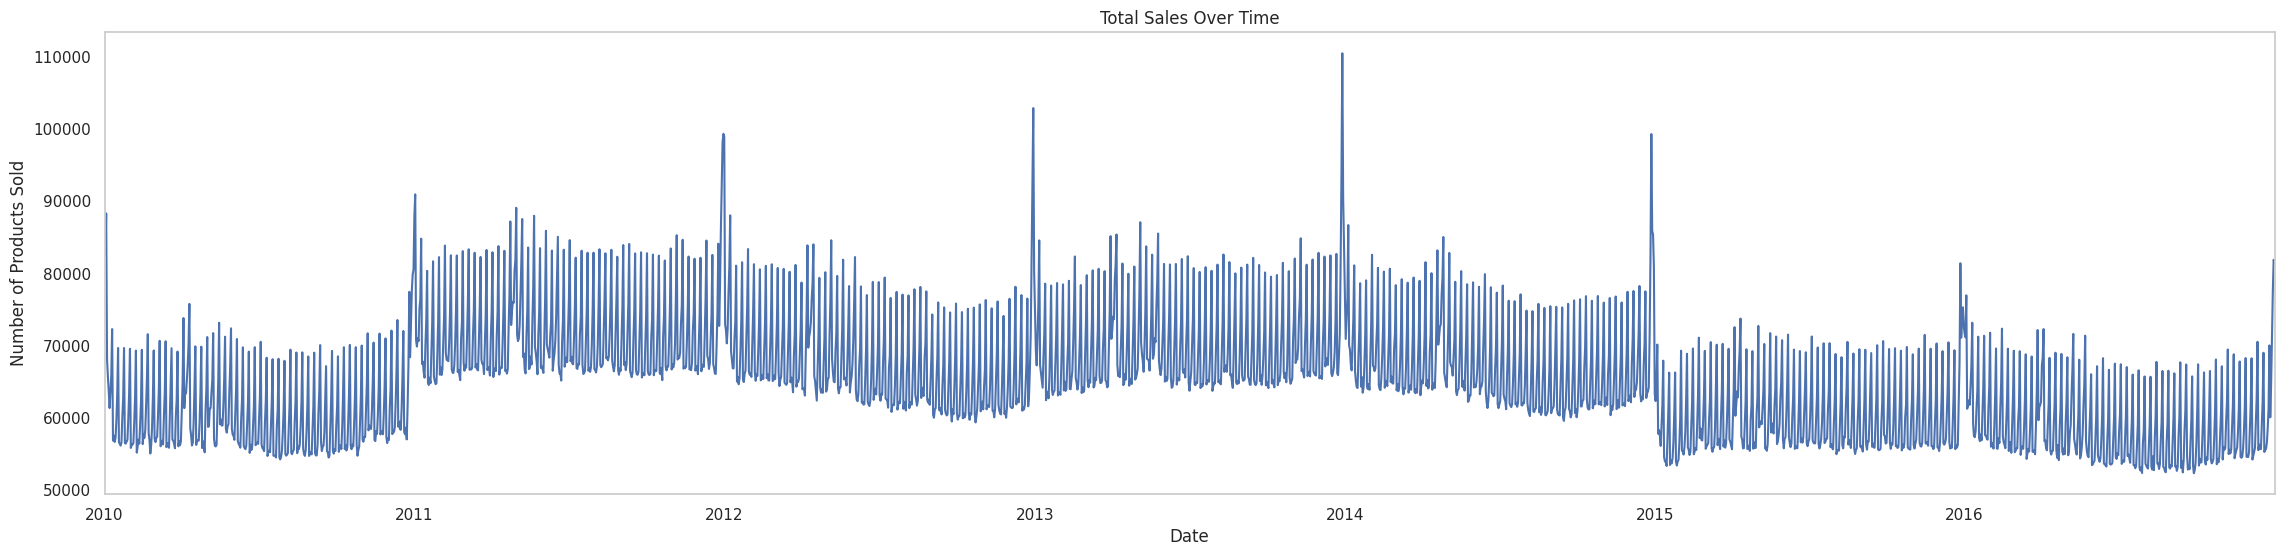

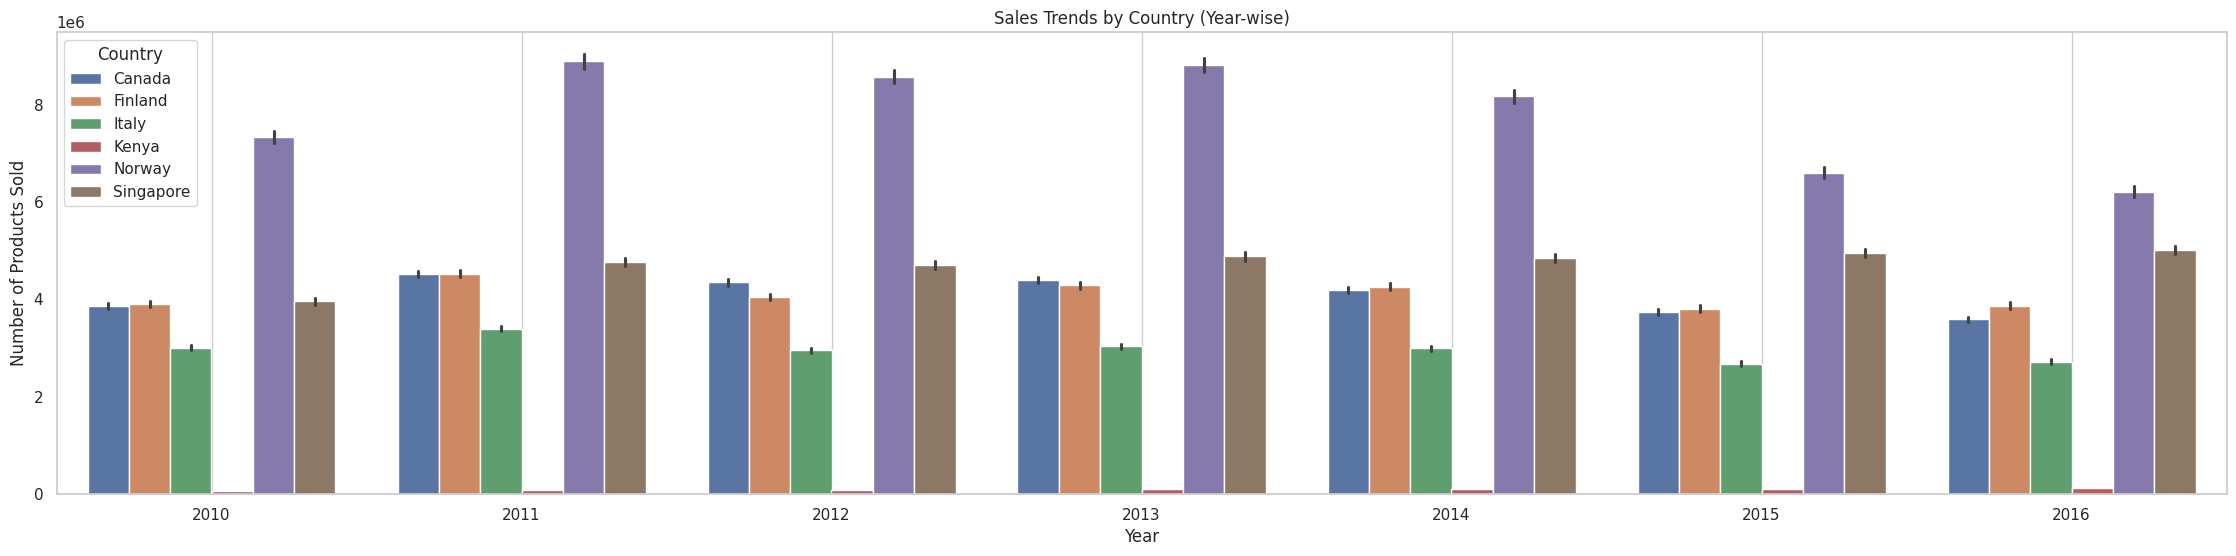

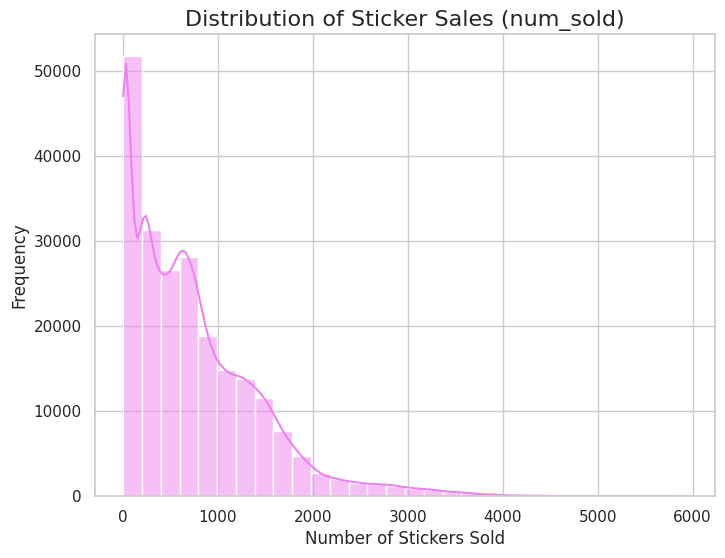

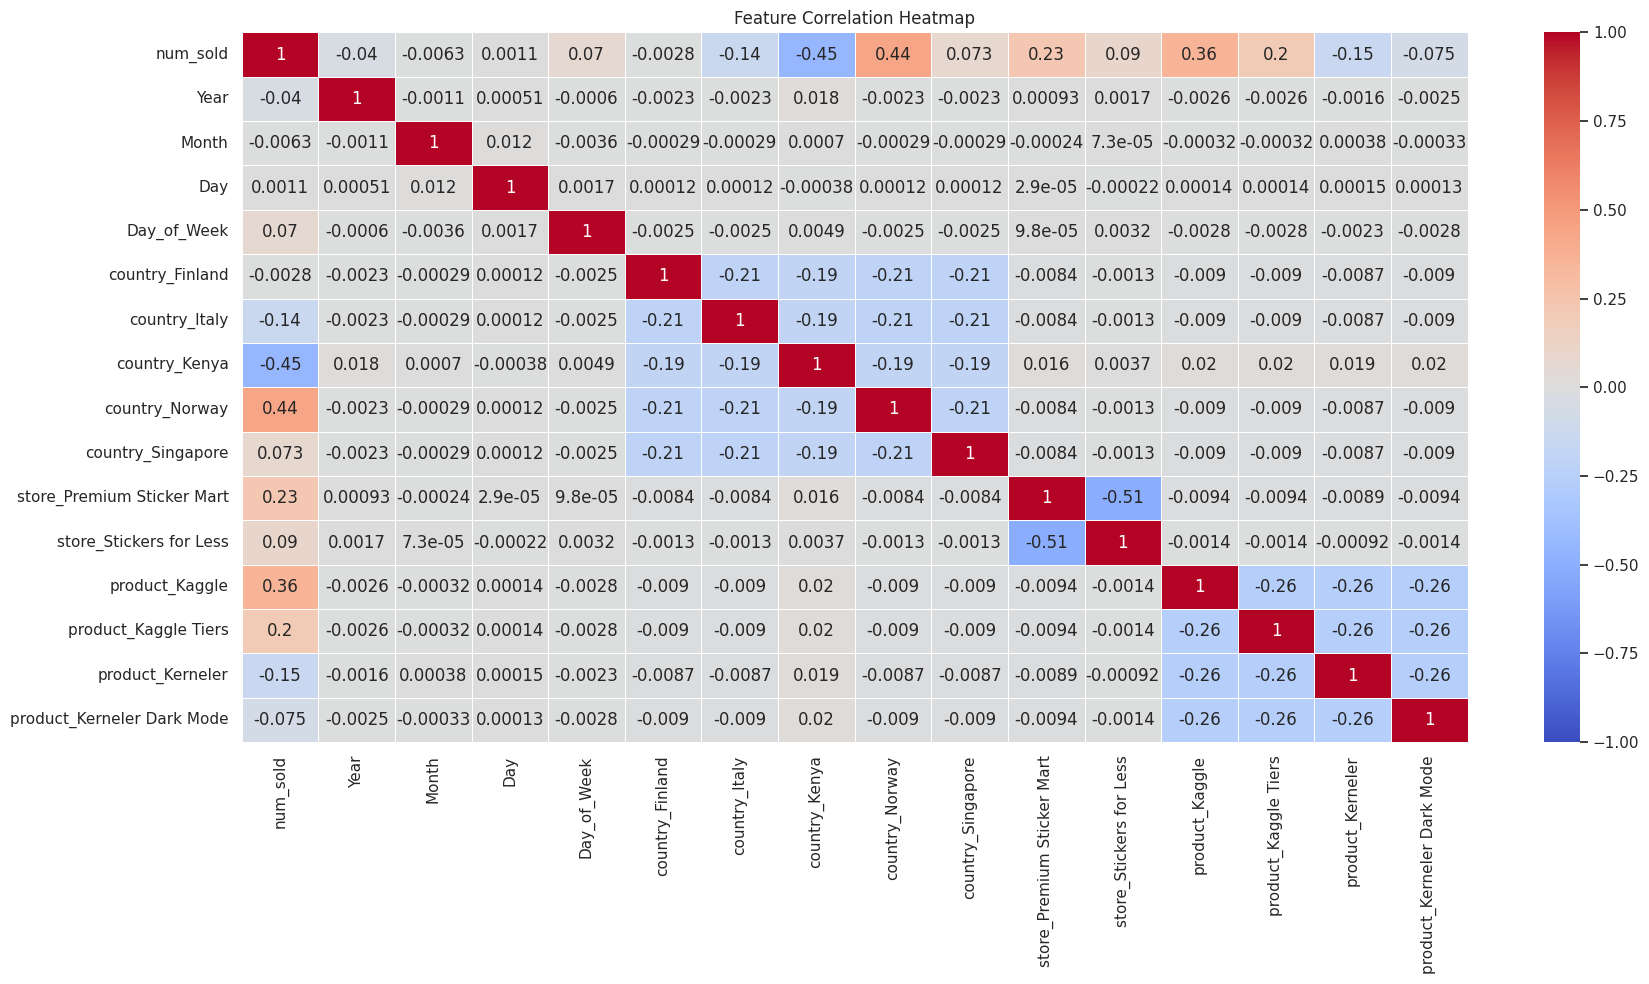


Correlation with target variable (num_sold):
num_sold                      1.000000
country_Norway                0.444573
product_Kaggle                0.356331
store_Premium Sticker Mart    0.231209
product_Kaggle Tiers          0.197389
store_Stickers for Less       0.089933
country_Singapore             0.073334
Day_of_Week                   0.069613
Day                           0.001137
country_Finland              -0.002843
Month                        -0.006255
Year                         -0.040462
product_Kerneler Dark Mode   -0.075360
country_Italy                -0.139527
product_Kerneler             -0.145131
country_Kenya                -0.449873
Name: num_sold, dtype: float64

Base Model Evaluation
Evaluation completed in 45.14 seconds
Random Forest MAPE: 0.0516
Evaluation completed in 3.52 seconds
XGBoost MAPE: 0.0459
Evaluation completed in 361.06 seconds
Attention Model MAPE: 0.2849

Cross-Validation
Random Forest CV MAPE: 0.0095
XGBoost CV MAPE: 0.0087


KeyboardInterrupt: 

In [5]:
# Forecasting Sticker Sales in Google Colab with T4 GPU Support
# Reset runtime and ensure T4 GPU is selected: Runtime > Change runtime type > T4 GPU > Save
# Restart runtime after changes

# Install only scikeras, use Colab's default scikit-learn
!pip install scikeras -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
import warnings
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.models import Model
from scikeras.wrappers import KerasRegressor
import time

# Verify GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)  # Avoid memory pre-allocation issues
    print("GPU detected and configured:", physical_devices)
else:
    print("No GPU detected. Ensure T4 GPU is selected and restart runtime (Runtime > Restart runtime).")

# Check versions
import sklearn
print("scikit-learn version:", sklearn.__version__)
print("TensorFlow version:", tf.__version__)

warnings.filterwarnings("ignore")

# Load Dataset
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print("train_data shape:", train_data.shape)
print("test_data shape:", test_data.shape)
print("sample_submission shape:", sample_submission.shape)

# Visualization (Before Preprocessing)
plt.figure(figsize=(28, 6))
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.groupby('date')['num_sold'].sum().plot(xlabel='Date', ylabel='Number of Products Sold', title='Total Sales Over Time')
plt.grid()
plt.show()

plt.figure(figsize=(28, 6))
sns.barplot(x=train_data['date'].dt.year, y=train_data['num_sold'], hue=train_data['country'], estimator='sum', palette='deep')
plt.title('Sales Trends by Country (Year-wise)')
plt.xlabel('Year')
plt.ylabel('Number of Products Sold')
plt.legend(title='Country')
plt.grid()
plt.show()

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.histplot(train_data['num_sold'], kde=True, bins=30, color='violet')
plt.title('Distribution of Sticker Sales (num_sold)', fontsize=16)
plt.xlabel('Number of Stickers Sold')
plt.ylabel('Frequency')
plt.show()

# Preprocessing
def preprocess_data(df):
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['Year'] = df['date'].dt.year
    df['Month'] = df['date'].dt.month
    df['Day'] = df['date'].dt.day
    df['Day_of_Week'] = df['date'].dt.dayofweek
    df.drop(['date', 'id'], axis=1, inplace=True, errors='ignore')
    return df

train_data = train_data.dropna()
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Encoding Categorical Columns
cat_cols = ['country', 'store', 'product']
train_data = pd.get_dummies(train_data, columns=cat_cols, drop_first=True)
test_data = pd.get_dummies(test_data, columns=cat_cols, drop_first=True)
test_data = test_data.reindex(columns=train_data.columns.drop('num_sold'), fill_value=0)  # Fixed from reindex_columns

# Define Features and Target
X = train_data.drop('num_sold', axis=1)
y = np.log1p(train_data['num_sold'])

# Correlation Matrix
correlation_matrix = train_data.corr()
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

print("\nCorrelation with target variable (num_sold):")
print(correlation_matrix['num_sold'].sort_values(ascending=False))

# Split Dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to NumPy arrays with float32 dtype
X_train = X_train.to_numpy().astype(np.float32)
X_val = X_val.to_numpy().astype(np.float32)
y_train = y_train.to_numpy().astype(np.float32)
y_val = y_val.to_numpy().astype(np.float32)
X = X.to_numpy().astype(np.float32)  # For cross-validation
y = y.to_numpy().astype(np.float32)
test_data = test_data.to_numpy().astype(np.float32)

# Evaluation Function with progress monitoring
def evaluate_model(model, X_train, X_val, y_train, y_val, is_tf_model=False):
    start_time = time.time()
    try:
        if is_tf_model:
            with tf.device('/GPU:0' if physical_devices else '/CPU:0'):
                model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0, validation_data=(X_val, y_val))
            y_pred = np.expm1(model.predict(X_val, verbose=0).flatten())
        else:
            model.fit(X_train, y_train)
            y_pred = np.expm1(model.predict(X_val))
        y_val_orig = np.expm1(y_val)
        mape_score = mean_absolute_percentage_error(y_val_orig, y_pred)
        print(f"Evaluation completed in {time.time() - start_time:.2f} seconds")
        return mape_score
    except Exception as e:
        print(f"Error evaluating model: {e}")
        print(f"Failed after {time.time() - start_time:.2f} seconds")
        return None

# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(1,), initializer='zeros', trainable=True)

    def call(self, inputs):
        e = tf.tanh(tf.matmul(inputs, self.W) + self.b)
        alpha = tf.nn.softmax(e, axis=-1)
        context = inputs * alpha
        return tf.reduce_sum(context, axis=-1, keepdims=True)

# Build Attention Model
def build_attention_model(input_shape, learning_rate=0.001):
    inputs = Input(shape=(input_shape,))
    x = Dense(64, activation='relu')(inputs)
    x = AttentionLayer()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['mape'])
    return model

# Base Models
print("\nBase Model Evaluation")
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_mape = evaluate_model(rf, X_train, X_val, y_train, y_val)
print(f"Random Forest MAPE: {rf_mape:.4f}")

xgb = XGBRegressor(random_state=42, verbosity=0, n_jobs=-1)
xgb_mape = evaluate_model(xgb, X_train, X_val, y_train, y_val)
print(f"XGBoost MAPE: {xgb_mape:.4f}")

attention_model = build_attention_model(X_train.shape[1])
attention_mape = evaluate_model(attention_model, X_train, X_val, y_train, y_val, is_tf_model=True)
if attention_mape is not None:
    print(f"Attention Model MAPE: {attention_mape:.4f}")
else:
    print("Attention Model evaluation failed.")

# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print("\nCross-Validation")
rf_cv_scores = cross_val_score(rf, X, y, scoring='neg_mean_absolute_percentage_error', cv=kf)
rf_cv_mape = -np.mean(rf_cv_scores)
print(f"Random Forest CV MAPE: {rf_cv_mape:.4f}")

xgb_cv_scores = cross_val_score(xgb, X, y, scoring='neg_mean_absolute_percentage_error', cv=kf)
xgb_cv_mape = -np.mean(xgb_cv_scores)
print(f"XGBoost CV MAPE: {xgb_cv_mape:.4f}")

attention_wrapped = KerasRegressor(model=lambda: build_attention_model(X_train.shape[1]), epochs=20, batch_size=32, verbose=0)
try:
    attention_cv_scores = cross_val_score(attention_wrapped, X, y, scoring='neg_mean_absolute_percentage_error', cv=kf)
    attention_cv_mape = -np.mean(attention_cv_scores)
    print(f"Attention Model CV MAPE: {attention_cv_mape:.4f}")
except Exception as e:
    print(f"Error in Attention Model cross-validation: {e}")
    attention_cv_mape = None

# Hyperparameter Tuning
print("\nHyperparameter Tuning")
rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
rf_random = RandomizedSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), param_distributions=rf_params, n_iter=20, scoring='neg_mean_absolute_percentage_error', cv=kf, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)
print(f"Best Random Forest Params: {rf_random.best_params_}")

xgb_params = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 6, 9], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0]}
xgb_random = RandomizedSearchCV(XGBRegressor(random_state=42, verbosity=0, n_jobs=-1), param_distributions=xgb_params, n_iter=20, scoring='neg_mean_absolute_percentage_error', cv=kf, random_state=42, n_jobs=-1)
xgb_random.fit(X_train, y_train)
print(f"Best XGBoost Params: {xgb_random.best_params_}")

attention_params = {'model__learning_rate': [0.001, 0.01, 0.1], 'epochs': [20, 30], 'batch_size': [32, 64]}
attention_random = RandomizedSearchCV(estimator=attention_wrapped, param_distributions=attention_params, n_iter=10, scoring='neg_mean_absolute_percentage_error', cv=kf, random_state=42, n_jobs=1)
try:
    attention_random.fit(X_train, y_train)
    print(f"Best Attention Model Params: {attention_random.best_params_}")
except Exception as e:
    print(f"Error in Attention Model hyperparameter tuning: {e}")
    attention_random = None

# Final Evaluation
print("\nFinal Model Evaluation")
rf_best = rf_random.best_estimator_
rf_best_mape = evaluate_model(rf_best, X_train, X_val, y_train, y_val)
print(f"Tuned Random Forest MAPE: {rf_best_mape:.4f}")

xgb_best = xgb_random.best_estimator_
xgb_best_mape = evaluate_model(xgb_best, X_train, X_val, y_train, y_val)
print(f"Tuned XGBoost MAPE: {xgb_best_mape:.4f}")

attention_best = attention_random.best_estimator_ if attention_random is not None else None
attention_best_mape = evaluate_model(attention_best, X_train, X_val, y_train, y_val, is_tf_model=True) if attention_best is not None else None
if attention_best_mape is not None:
    print(f"Tuned Attention Model MAPE: {attention_best_mape:.4f}")
else:
    print("Tuned Attention Model evaluation failed or tuning not completed.")

# Model Comparison
models_comparison = pd.DataFrame({
    'Model': ['Random Forest (Base)', 'XGBoost (Base)', 'Attention Model (Base)', 'Random Forest (Tuned)', 'XGBoost (Tuned)', 'Attention Model (Tuned)'],
    'MAPE': [rf_mape, xgb_mape, attention_mape if attention_mape is not None else np.nan,
             rf_best_mape, xgb_best_mape, attention_best_mape if attention_best_mape is not None else np.nan]
})
print("\nModel Comparison Table:")
print(models_comparison)

# Visualization of Model Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='MAPE', data=models_comparison, palette='viridis')
plt.title('Model Performance Comparison (MAPE)')
plt.ylabel('Mean Absolute Percentage Error')
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Feature Importance (XGBoost)
best_model = xgb_best
importance_df = pd.DataFrame({"Feature Name": X.columns, "Importance": best_model.feature_importances_}).sort_values(by="Importance", ascending=False)
print("\nFeature Importance Table (XGBoost):")
print(importance_df)

plt.figure(figsize=(10, 6))
plt.bar(range(len(best_model.feature_importances_)), best_model.feature_importances_)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

# Residual Analysis (All Models)
plt.figure(figsize=(12, 8))
for model, name in [(rf, 'Random Forest (Base)'), (xgb, 'XGBoost (Base)'), (xgb_best, 'XGBoost (Tuned)')]:
    residuals = np.expm1(y_val) - np.expm1(model.predict(X_val))
    sns.kdeplot(residuals, label=name, fill=True)
if attention_mape is not None:
    residuals_attention = np.expm1(y_val) - np.expm1(attention_model.predict(X_val, verbose=0).flatten())
    sns.kdeplot(residuals_attention, label='Attention Model (Base)', fill=True)
if attention_best_mape is not None:
    residuals_attention_best = np.expm1(y_val) - np.expm1(attention_best.predict(X_val, verbose=0).flatten())
    sns.kdeplot(residuals_attention_best, label='Attention Model (Tuned)', fill=True)
plt.title('Residuals Distribution Comparison', fontsize=16)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()

# Attention Layer Weights Analysis (Tuned Model, if successful)
if attention_best_mape is not None:
    attention_weights = attention_random.best_estimator_.model_.layers[1].get_weights()[0].flatten()
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(attention_weights)), attention_weights)
    plt.title('Tuned Attention Layer Weights')
    plt.xlabel('Feature Index (After Dense Layer)')
    plt.ylabel('Weight Value')
    plt.grid()
    plt.show()

# Prediction and Submission (XGBoost)
final_preds = np.expm1(xgb_best.predict(test_data))
submission = pd.DataFrame({'id': sample_submission['id'], 'num_sold': final_preds})
submission.to_csv('submission_xgb_rf.csv', index=False)
print("Submission file saved as submission_xgb_rf.csv")
print("\nFinal Predicted Entries (XGBoost):")
print(submission.head())

# Prediction and Submission (Tuned Attention Model, if successful)
if attention_best_mape is not None:
    final_preds_attention = np.expm1(attention_best.predict(test_data, verbose=0).flatten())
    submission_attention = pd.DataFrame({'id': sample_submission['id'], 'num_sold': final_preds_attention})
    submission_attention.to_csv('submission_attention.csv', index=False)
    print("Submission file saved as submission_attention.csv")
    print("\nFinal Predicted Entries (Tuned Attention Model):")
    print(submission_attention.head())

Num GPUs Available:  1
GPU detected and configured: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
scikit-learn version: 1.5.2
TensorFlow version: 2.18.0
train_data shape: (230130, 6)
test_data shape: (98550, 5)
sample_submission shape: (98550, 2)


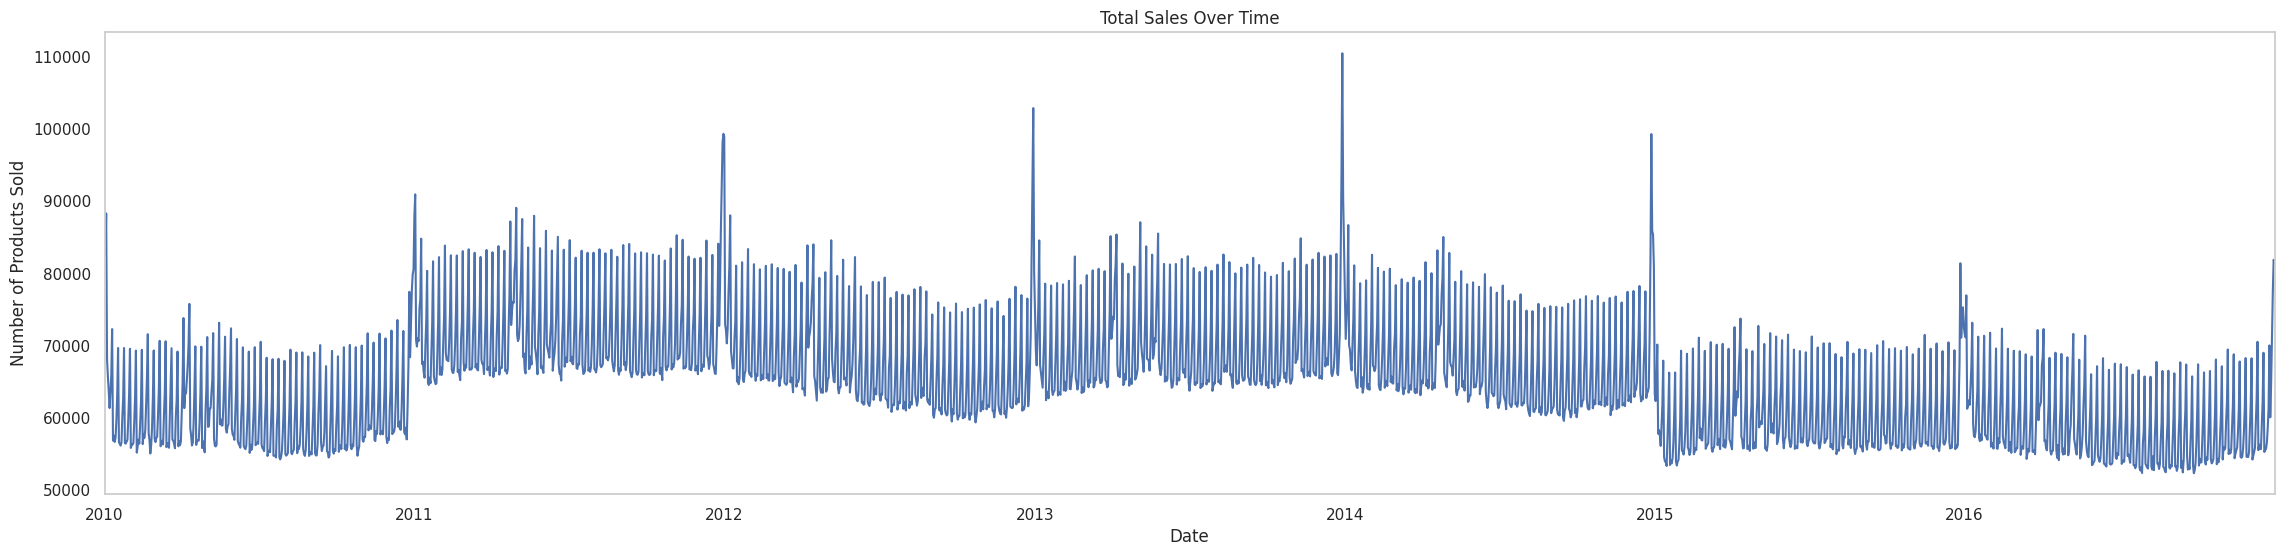

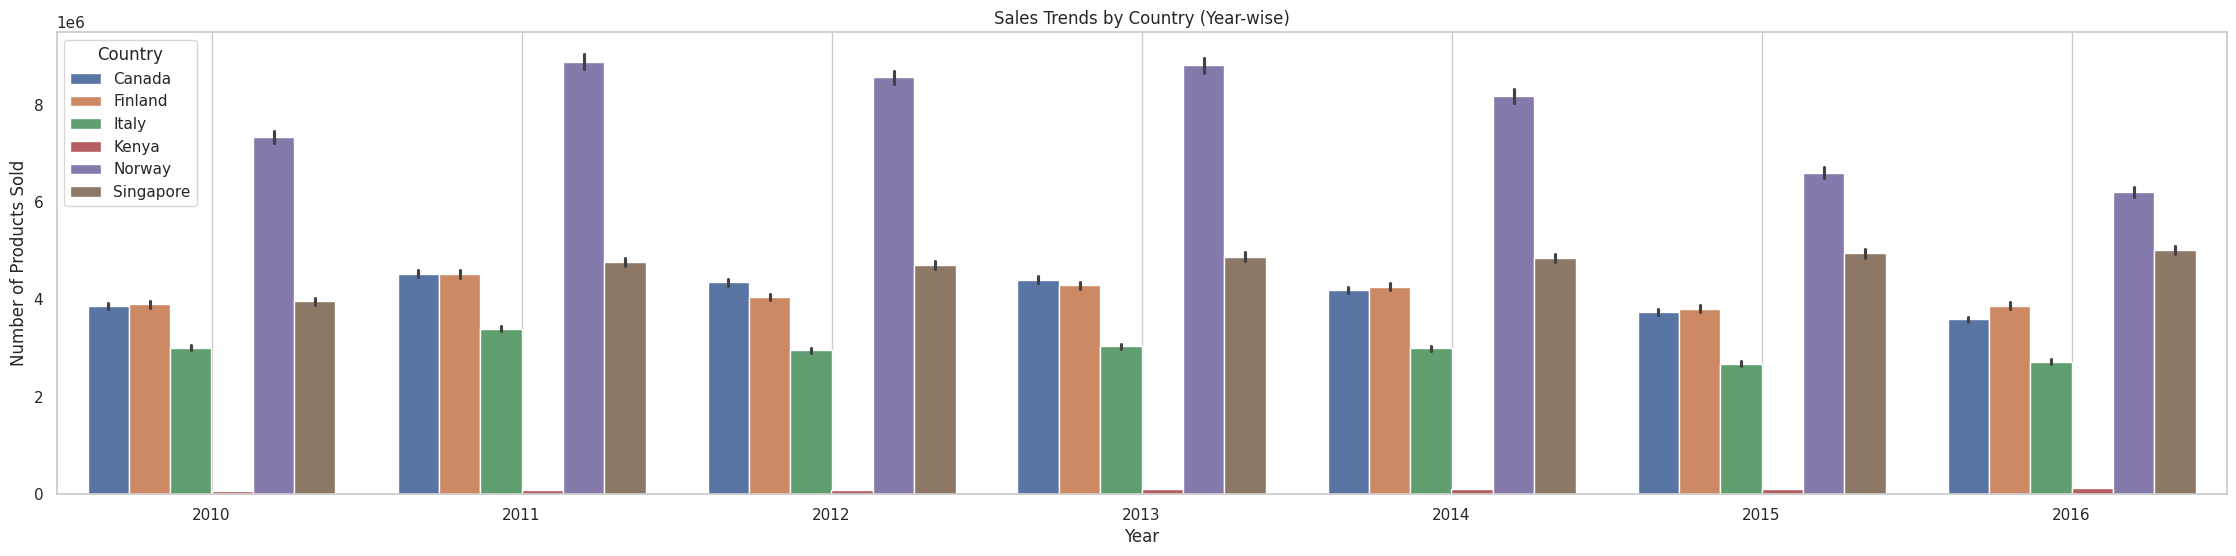

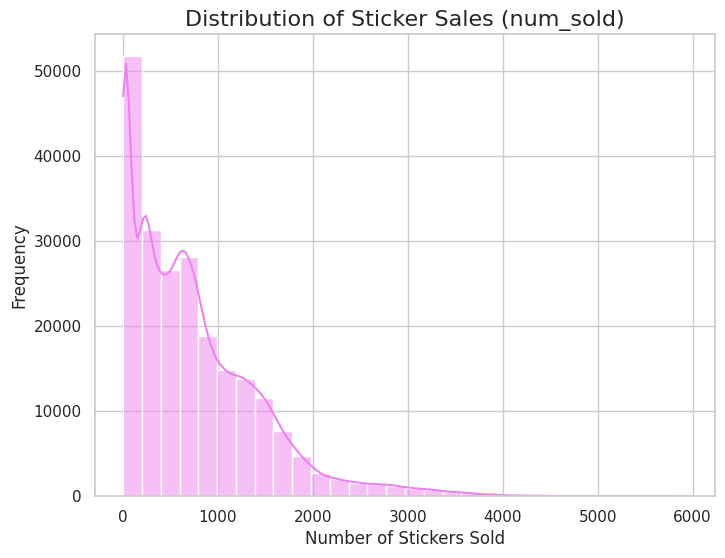

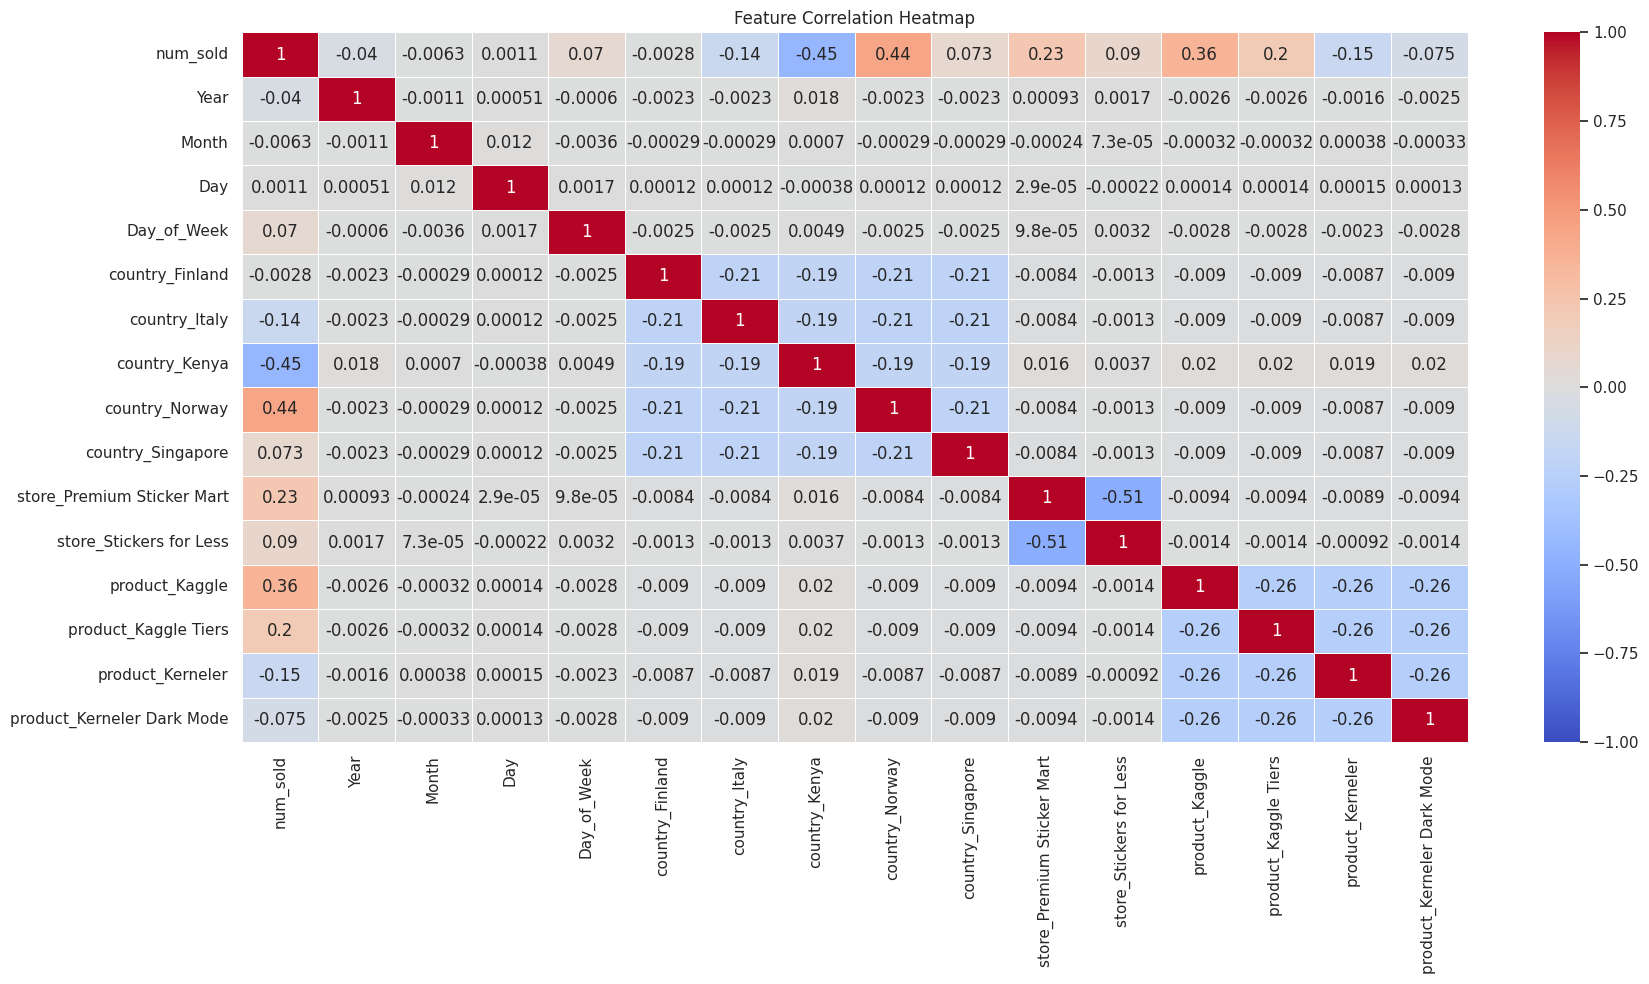


Correlation with target variable (num_sold):
num_sold                      1.000000
country_Norway                0.444573
product_Kaggle                0.356331
store_Premium Sticker Mart    0.231209
product_Kaggle Tiers          0.197389
store_Stickers for Less       0.089933
country_Singapore             0.073334
Day_of_Week                   0.069613
Day                           0.001137
country_Finland              -0.002843
Month                        -0.006255
Year                         -0.040462
product_Kerneler Dark Mode   -0.075360
country_Italy                -0.139527
product_Kerneler             -0.145131
country_Kenya                -0.449873
Name: num_sold, dtype: float64
X_train shape: (177007, 15) dtype: float32
y_train shape: (177007,) dtype: float32

Base Model Evaluation
Evaluation completed in 55.39 seconds
Random Forest MAPE: 0.0516
Evaluation completed in 1.29 seconds
XGBoost MAPE: 0.0459
Epoch 1/20
5532/5532 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 26124.7

In [ ]:
# Forecasting Sticker Sales in Google Colab with T4 GPU Support
# Reset runtime and ensure T4 GPU is selected: Runtime > Change runtime type > T4 GPU > Save
# Restart runtime after changes

# Install only scikeras, use Colab's default scikit-learn
!pip install scikeras -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
import warnings
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.models import Model
from scikeras.wrappers import KerasRegressor
import time

# Verify GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)  # Avoid memory pre-allocation issues
    print("GPU detected and configured:", physical_devices)
else:
    print("No GPU detected. Ensure T4 GPU is selected and restart runtime (Runtime > Restart runtime).")

# Check versions
import sklearn
print("scikit-learn version:", sklearn.__version__)
print("TensorFlow version:", tf.__version__)

warnings.filterwarnings("ignore")

# Load Dataset
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

print("train_data shape:", train_data.shape)
print("test_data shape:", test_data.shape)
print("sample_submission shape:", sample_submission.shape)

# Visualization (Before Preprocessing)
plt.figure(figsize=(28, 6))
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.groupby('date')['num_sold'].sum().plot(xlabel='Date', ylabel='Number of Products Sold', title='Total Sales Over Time')
plt.grid()
plt.show()

plt.figure(figsize=(28, 6))
sns.barplot(x=train_data['date'].dt.year, y=train_data['num_sold'], hue=train_data['country'], estimator='sum', palette='deep')
plt.title('Sales Trends by Country (Year-wise)')
plt.xlabel('Year')
plt.ylabel('Number of Products Sold')
plt.legend(title='Country')
plt.grid()
plt.show()

sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.histplot(train_data['num_sold'], kde=True, bins=30, color='violet')
plt.title('Distribution of Sticker Sales (num_sold)', fontsize=16)
plt.xlabel('Number of Stickers Sold')
plt.ylabel('Frequency')
plt.show()

# Preprocessing
def preprocess_data(df):
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['Year'] = df['date'].dt.year
    df['Month'] = df['date'].dt.month
    df['Day'] = df['date'].dt.day
    df['Day_of_Week'] = df['date'].dt.dayofweek
    df.drop(['date', 'id'], axis=1, inplace=True, errors='ignore')
    return df

train_data = train_data.dropna()
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Encoding Categorical Columns
cat_cols = ['country', 'store', 'product']
train_data = pd.get_dummies(train_data, columns=cat_cols, drop_first=True)
test_data = pd.get_dummies(test_data, columns=cat_cols, drop_first=True)
test_data = test_data.reindex(columns=train_data.columns.drop('num_sold'), fill_value=0)

# Define Features and Target
X = train_data.drop('num_sold', axis=1)
y = np.log1p(train_data['num_sold'])

# Correlation Matrix
correlation_matrix = train_data.corr()
plt.figure(figsize=(18, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

print("\nCorrelation with target variable (num_sold):")
print(correlation_matrix['num_sold'].sort_values(ascending=False))

# Split Dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to NumPy arrays with float32 dtype
X_train = X_train.to_numpy().astype(np.float32)
X_val = X_val.to_numpy().astype(np.float32)
y_train = y_train.to_numpy().astype(np.float32)
y_val = y_val.to_numpy().astype(np.float32)
X = X.to_numpy().astype(np.float32)  # For cross-validation
y = y.to_numpy().astype(np.float32)
test_data = test_data.to_numpy().astype(np.float32)

# Check data formats
print("X_train shape:", X_train.shape, "dtype:", X_train.dtype)
print("y_train shape:", y_train.shape, "dtype:", y_train.dtype)

# Evaluation Function with progress monitoring and verbose logging
def evaluate_model(model, X_train, X_val, y_train, y_val, is_tf_model=False):
    start_time = time.time()
    try:
        if is_tf_model:
            with tf.device('/GPU:0' if physical_devices else '/CPU:0'):
                history = model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(X_val, y_val))
                print("Training history (loss, mape):", history.history)
            y_pred = np.expm1(model.predict(X_val, verbose=0).flatten())
        else:
            model.fit(X_train, y_train)
            y_pred = np.expm1(model.predict(X_val))
        y_val_orig = np.expm1(y_val)
        mape_score = mean_absolute_percentage_error(y_val_orig, y_pred)
        print(f"Evaluation completed in {time.time() - start_time:.2f} seconds")
        return mape_score
    except Exception as e:
        print(f"Error evaluating model: {e}")
        print(f"Failed after {time.time() - start_time:.2f} seconds")
        return None

# Custom Attention Layer
class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(1,), initializer='zeros', trainable=True)

    def call(self, inputs):
        e = tf.tanh(tf.matmul(inputs, self.W) + self.b)
        alpha = tf.nn.softmax(e, axis=-1)
        context = inputs * alpha
        return tf.reduce_sum(context, axis=-1, keepdims=True)

# Build Attention Model
def build_attention_model(input_shape, learning_rate=0.001):
    inputs = Input(shape=(input_shape,))
    x = Dense(64, activation='relu')(inputs)
    x = AttentionLayer()(x)
    x = Dense(32, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse', metrics=['mape'])
    return model

# Base Models
print("\nBase Model Evaluation")
rf = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_mape = evaluate_model(rf, X_train, X_val, y_train, y_val)
print(f"Random Forest MAPE: {rf_mape:.4f}")

xgb = XGBRegressor(random_state=42, verbosity=0, n_jobs=-1)
xgb_mape = evaluate_model(xgb, X_train, X_val, y_train, y_val)
print(f"XGBoost MAPE: {xgb_mape:.4f}")

attention_model = build_attention_model(X_train.shape[1])
attention_mape = evaluate_model(attention_model, X_train, X_val, y_train, y_val, is_tf_model=True)
if attention_mape is not None:
    print(f"Attention Model MAPE: {attention_mape:.4f}")
else:
    print("Attention Model evaluation failed.")

# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print("\nCross-Validation")
rf_cv_scores = cross_val_score(rf, X, y, scoring='neg_mean_absolute_percentage_error', cv=kf)
rf_cv_mape = -np.mean(rf_cv_scores)
print(f"Random Forest CV MAPE: {rf_cv_mape:.4f}")

xgb_cv_scores = cross_val_score(xgb, X, y, scoring='neg_mean_absolute_percentage_error', cv=kf)
xgb_cv_mape = -np.mean(xgb_cv_scores)
print(f"XGBoost CV MAPE: {xgb_cv_mape:.4f}")

attention_wrapped = KerasRegressor(model=lambda: build_attention_model(X_train.shape[1]), epochs=10, batch_size=16, verbose=0)  # Reduced for speed
try:
    attention_cv_scores = cross_val_score(attention_wrapped, X, y, scoring='neg_mean_absolute_percentage_error', cv=kf)
    attention_cv_mape = -np.mean(attention_cv_scores)
    print(f"Attention Model CV MAPE: {attention_cv_mape:.4f}")
except Exception as e:
    print(f"Error in Attention Model cross-validation: {e}")
    attention_cv_mape = None

# Hyperparameter Tuning
print("\nHyperparameter Tuning")
rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20, 30], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
rf_random = RandomizedSearchCV(RandomForestRegressor(random_state=42, n_jobs=1), param_distributions=rf_params, n_iter=10, scoring='neg_mean_absolute_percentage_error', cv=kf, random_state=42, n_jobs=1)  # Reduced for speed
rf_random.fit(X_train, y_train)
print(f"Best Random Forest Params: {rf_random.best_params_}")

xgb_params = {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 6, 9], 'subsample': [0.8, 1.0], 'colsample_bytree': [0.8, 1.0]}
xgb_random = RandomizedSearchCV(XGBRegressor(random_state=42, verbosity=0, n_jobs=1), param_distributions=xgb_params, n_iter=10, scoring='neg_mean_absolute_percentage_error', cv=kf, random_state=42, n_jobs=1)  # Reduced for speed
xgb_random.fit(X_train, y_train)
print(f"Best XGBoost Params: {xgb_random.best_params_}")

attention_params = {'model__learning_rate': [0.001, 0.01, 0.1], 'epochs': [5, 10], 'batch_size': [16, 32]}  # Further reduced for speed
attention_random = RandomizedSearchCV(estimator=attention_wrapped, param_distributions=attention_params, n_iter=5, scoring='neg_mean_absolute_percentage_error', cv=kf, random_state=42, n_jobs=1)
try:
    attention_random.fit(X_train, y_train)
    print(f"Best Attention Model Params: {attention_random.best_params_}")
except Exception as e:
    print(f"Error in Attention Model hyperparameter tuning: {e}")
    attention_random = None

# Final Evaluation
print("\nFinal Model Evaluation")
rf_best = rf_random.best_estimator_
rf_best_mape = evaluate_model(rf_best, X_train, X_val, y_train, y_val)
print(f"Tuned Random Forest MAPE: {rf_best_mape:.4f}")

xgb_best = xgb_random.best_estimator_
xgb_best_mape = evaluate_model(xgb_best, X_train, X_val, y_train, y_val)
print(f"Tuned XGBoost MAPE: {xgb_best_mape:.4f}")

attention_best = attention_random.best_estimator_ if attention_random is not None else None
attention_best_mape = evaluate_model(attention_best, X_train, X_val, y_train, y_val, is_tf_model=True) if attention_best is not None else None
if attention_best_mape is not None:
    print(f"Tuned Attention Model MAPE: {attention_best_mape:.4f}")
else:
    print("Tuned Attention Model evaluation failed or tuning not completed.")

# Model Comparison
models_comparison = pd.DataFrame({
    'Model': ['Random Forest (Base)', 'XGBoost (Base)', 'Attention Model (Base)', 'Random Forest (Tuned)', 'XGBoost (Tuned)', 'Attention Model (Tuned)'],
    'MAPE': [rf_mape, xgb_mape, attention_mape if attention_mape is not None else np.nan,
             rf_best_mape, xgb_best_mape, attention_best_mape if attention_best_mape is not None else np.nan]
})
print("\nModel Comparison Table:")
print(models_comparison)

# Visualization of Model Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='MAPE', data=models_comparison, palette='viridis')
plt.title('Model Performance Comparison (MAPE)')
plt.ylabel('Mean Absolute Percentage Error')
plt.xticks(rotation=45)
plt.grid()
plt.show()

# Feature Importance (XGBoost)
best_model = xgb_best
importance_df = pd.DataFrame({"Feature Name": X.columns, "Importance": best_model.feature_importances_}).sort_values(by="Importance", ascending=False)
print("\nFeature Importance Table (XGBoost):")
print(importance_df)

plt.figure(figsize=(10, 6))
plt.bar(range(len(best_model.feature_importances_)), best_model.feature_importances_)
plt.title("Feature Importance (XGBoost)")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

# Residual Analysis (All Models)
plt.figure(figsize=(12, 8))
for model, name in [(rf, 'Random Forest (Base)'), (xgb, 'XGBoost (Base)'), (xgb_best, 'XGBoost (Tuned)')]:
    residuals = np.expm1(y_val) - np.expm1(model.predict(X_val))
    sns.kdeplot(residuals, label=name, fill=True)
if attention_mape is not None:
    residuals_attention = np.expm1(y_val) - np.expm1(attention_model.predict(X_val, verbose=0).flatten())
    sns.kdeplot(residuals_attention, label='Attention Model (Base)', fill=True)
if attention_best_mape is not None:
    residuals_attention_best = np.expm1(y_val) - np.expm1(attention_best.predict(X_val, verbose=0).flatten())
    sns.kdeplot(residuals_attention_best, label='Attention Model (Tuned)', fill=True)
plt.title('Residuals Distribution Comparison', fontsize=16)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()

# Attention Layer Weights Analysis (Tuned Model, if successful)
if attention_best_mape is not None:
    attention_weights = attention_random.best_estimator_.model_.layers[1].get_weights()[0].flatten()
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(attention_weights)), attention_weights)
    plt.title('Tuned Attention Layer Weights')
    plt.xlabel('Feature Index (After Dense Layer)')
    plt.ylabel('Weight Value')
    plt.grid()
    plt.show()

# Prediction and Submission (XGBoost)
final_preds = np.expm1(xgb_best.predict(test_data))
submission = pd.DataFrame({'id': sample_submission['id'], 'num_sold': final_preds})
submission.to_csv('submission_xgb_rf.csv', index=False)
print("Submission file saved as submission_xgb_rf.csv")
print("\nFinal Predicted Entries (XGBoost):")
print(submission.head())

# Prediction and Submission (Tuned Attention Model, if successful)
if attention_best_mape is not None:
    final_preds_attention = np.expm1(attention_best.predict(test_data, verbose=0).flatten())
    submission_attention = pd.DataFrame({'id': sample_submission['id'], 'num_sold': final_preds_attention})
    submission_attention.to_csv('submission_attention.csv', index=False)
    print("Submission file saved as submission_attention.csv")
    print("\nFinal Predicted Entries (Tuned Attention Model):")
    print(submission_attention.head())